In [1]:
import importlib
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
import pathlib
import numpy as np
#np.random.seed(42) TODO necessary?
import torch

from torch.utils.data import DataLoader

import json

import pandas as pd

from Data_splitting import canton_split, build_train_test_sets

import time

from functions import features_change

column_names = ['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER',
       'GEM_FLAECH', 'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code',
       'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2',
       '25-65_2', '65+_2', 'canton_code_2', 'unemployment_2', 'gdp_2', 'flow']


In [2]:
def split_data_respect_years(data, num_splits, random_state=42):
    # distributes the data (2D numpy array) into num_splits (int) different buckets, roughly evenly.
    # Important: assures that all years of the same (commune_id, commune_id2) pair go into the same bucket
    # Returns INDICES of rows to use in each split, not the data itself! (similar to KFold.split)
    pass
    kfolds = KFold(n_splits=num_splits, shuffle=True, random_state=random_state)
    col_indices = [column_names.index("commune_1"), column_names.index("commune_2")]
    unique_pairs, inverse = np.unique(data[:, col_indices], axis=0, return_inverse=True)
    for train_pairs_index, val_pairs_index in kfolds.split(unique_pairs):
        #print("Hi", train_pairs_index)
        full_train_mask = np.isin(inverse, train_pairs_index)
        full_val_mask = np.isin(inverse, val_pairs_index)
        assert((full_train_mask == ~full_val_mask).all())
        indices = np.arange(len(data))
        yield indices[full_train_mask], indices[full_val_mask]

test_array = np.array([
    [1,2,3],
    [1,2,4],
    [1,2,5],
    [2,2,3],
    [2,2,4],
    [2,2,5],
    [3,2,3],
    [3,2,4],
    [3,2,5],
    [1,3,3],
    [4,2,4],
    [4,2,5],
    [5,2,5],
    [5,2,4],
])

for train_index, val_index in split_data_respect_years(test_array, 3):
    print(train_index, val_index, test_array[val_index])
    
# TODO: Is commune id enough to identify a commune or is canton id necessary?

[ 3  4  5  6  7  8 10 11 12 13] [0 1 2 9] [[1 2 3]
 [1 2 4]
 [1 2 5]
 [1 3 3]]
[ 0  1  2  6  7  8  9 10 11] [ 3  4  5 12 13] [[2 2 3]
 [2 2 4]
 [2 2 5]
 [5 2 5]
 [5 2 4]]
[ 0  1  2  3  4  5  9 12 13] [ 6  7  8 10 11] [[3 2 3]
 [3 2 4]
 [3 2 5]
 [4 2 4]
 [4 2 5]]


In [3]:
def train_model(x_train, y_train, x_val, y_val, model_name, **kwargs):#, num_epochs, train_data, val_data, **model_training_params):
    #try:
        # TODO: Warning: If module changes, please restart interpreter (i.e. close this notebook once)
        mod = importlib.import_module(f'models.{model_name}')

        #print(mod)
        #print(y_val.shape, x_val.shape)
        #print(kwargs)
        return mod.train_model(x_train, y_train, x_val, y_val, **kwargs)
    #except Exception as e:
        #print(f"Exception occured: {e}")

In [4]:
# TODO slow for large number of configs for the same model
# Basically, one file is kept per model and a JSON is written to it containing
# a list of config information dictionaries.
# each dictionary contains train_stats, model_name (redundant), config parameters
# Before a config is used to train and evaluate a new model, it is checked that the config doesn't already have such an entry
def dump_file(train_stats, model_name, **config):

    file_path = pathlib.Path(f"results/{model_name}.json")

    full_struct = {
        "train_stats": train_stats,
        "model_name": model_name,
        "config": config,
    }
    if file_path.exists():
        with open(file_path, "r") as f:
            old_config_infos = json.load(f)
    else:
        old_config_infos = []

    old_config_infos.append(full_struct)

    with open(file_path, "w") as f:
        json.dump(old_config_infos, f)

def assert_is_new(model_name, **config):
    file_path = pathlib.Path(f"results/{model_name}.json")
    if file_path.exists():
        with open(file_path, "r") as f:
            config_infos = json.load(f)
            for c_info in config_infos:
                if c_info["config"] == config:
                    raise RuntimeError("Configuration was already checked. Should be skipped!")
        

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# TODO never tested with gpu!
# prepare data
NUM_FOLDS = 3 #5 #3 #5
#kfolds = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

#data_path = pathlib.Path("../data/data.npy")
#data = np.load(data_path)[:, :]
#data_tensor = torch.from_numpy(data).to(device, dtype=torch.float32)
#print(type(data_tensor))

In [6]:
data_path = pathlib.Path("../data/data_y_v2.npy")
data = np.load(data_path, mmap_mode="r")
temp = data.mean(axis=0)
print(data.shape)
print(temp)

df = pd.DataFrame(data, columns=['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER',
       'GEM_FLAECH', 'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code',
       'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2',
       '25-65_2', '65+_2', 'canton_code_2', 'unemployment_2', 'gdp_2', 'flow'])

logscale_features = ['distance', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts',
       'GEM_FLAECH', 'EINWOHNERZ', '0-25', '25-65', '65+',
       'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2',
       '25-65_2', '65+_2', 'unemployment_2', 'gdp_2'] # FLOW NOT INCLUDED SO FAR!

df = features_change(df, logscale_features, "log") # TODO 

# Canton 2 (Bern) serves as test data. The training data will later be split further for crossvalidation
# THe others are taken out for efficiency
train_df, test_df = canton_split(df, canton_ids=[2])#,0,5,6,7,8,9,11,14,16,23])#, zero_drop_ratio=0.0)#[2] #, 0,  1, 5, 8,  9, 11, 13, 14, 15, 16, 23, 24])

print(len(train_df), len(test_df))

# TODO remove?
to_remove = ['commune_1', 'commune_2', 'year', 'BFS_NUMMER', 'canton_code','BFS_NUMMER_2', 'canton_code_2']
to_keep = [col for col in df.columns if col not in to_remove]

# TODO: Do in numpy itself
def useful_columns_as_numpy(dataframe):
    return dataframe[to_keep].to_numpy()

#train_df = 

#train_data = train_df.to_numpy()
#test_data = test_df.to_numpy()
train_data = useful_columns_as_numpy(train_df)
test_data = useful_columns_as_numpy(test_df)

test_df = None
train_df = None
df = None

def drop_zero_flows(data, drop_ratio=0.5, random_state=37):
    rng = np.random.default_rng(random_state)
    zero_mask = (data[:, -1] == 0)
    
    zero_flow_indices = np.arange(len(data))[zero_mask]
    keep_zero_indices = rng.choice(zero_flow_indices, round(len(zero_flow_indices) * (1-drop_ratio)), replace=False)
    
    final_mask = (~zero_mask)
    final_mask[keep_zero_indices] = True
    assert(np.all(data[~final_mask, -1] == 0)) # TODO remove
    return data[final_mask]

print(train_data.shape)
train_data = drop_zero_flows(train_data, 0.9)#0.5)
print(train_data.shape)
print(np.count_nonzero(train_data[:,-1]))

(19237044, 37)
[3.30788327e+03 3.30788327e+03 1.07071131e+05 2.01900319e+03
 3.88338896e+03 3.88338896e+03 1.94030140e+03 1.97099393e+03
 4.67352896e+02 1.54951332e+01 7.96954875e+00 1.04625950e-01
 3.30788327e+03 1.83267990e+03 3.85408372e+03 9.52876804e+02
 2.23124571e+03 8.16981645e+02 1.36833708e+01 8.48306376e+03
 4.37591823e+04 1.94030140e+03 1.97099393e+03 4.67352896e+02
 1.54951332e+01 7.96954875e+00 1.04625950e-01 3.30788327e+03
 1.83267990e+03 3.85408372e+03 9.52876804e+02 2.23124571e+03
 8.16981645e+02 1.36833708e+01 8.48306376e+03 4.37591823e+04
 5.18717377e-01]
Splitting with canton [2] as test set:
Total flows: 19,237,044
Train size: 13,712,244 rows (71.3%)
Test size: 5,524,800 rows (28.7%)
Test cantons: [2]
13712244 5524800
(13712244, 30)
(1560099, 30)
209861


In [ ]:
zero_per_nonzero_ratio = np.sum((train_data[:,-1] == 0)) / np.sum((train_data[:,-1] != 0)) #* 100 # TEMP #TODO check
print(np.sum(train_data[train_data[:,-1] == 0], axis=0))
print(zero_per_nonzero_ratio)

# Dictionary of model configurations. Will be used for training one by one.
# Note: must contain model_name that has to match file name
configs = [
    #{"model_name": "simpleFCNN", "num_epochs": 5, "batch_size": 32, "lr": 1e-3, "nodes_per_layer": 10, "num_hidden_layers": 4, },
    #{"model_name": "simpleFCNN", "num_epochs": 10, "batch_size": 1024, "lr": 1e-3, "patience": 5, "loss": "MSE", "layer_nodes": [64,48,32], "weight_decay": 1e-5},
    
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-4, "patience": 10, "layer_nodes": [64,48,32], "weight_decay": 1e-6},
    #------------------------------------------------------
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-4, "patience": 2, "layer_nodes": [32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-3, "patience": 2, "layer_nodes": [48,32], "weight_decay": 1e-4},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 64, "lr": 1e-5, "patience": 10, "layer_nodes": [64,48,48,48,32], "weight_decay": 1e-8},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 64, "lr": 1e-4, "patience": 10, "layer_nodes": [64,48,32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 64, "lr": 1e-4, "patience": 10, "layer_nodes": [128,64,32], "weight_decay": 1e-6},
    

    
    # from 1
    #{"model_name": "classifierFCNN", "num_epochs": 1, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-4, "patience": 2, "layer_nodes": [32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-4, "patience": 2, "layer_nodes": [32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-4, "patience": 10, "layer_nodes": [32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-4, "patience": 10, "layer_nodes": [32, 32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-5, "patience": 10, "layer_nodes": [32, 32], "weight_decay": 2e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": 1, "batch_size": 512, "lr": 1e-4, "patience": 10, "layer_nodes": [32, 32], "weight_decay": 1e-6},
    # from 3
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-5, "patience": 10, "layer_nodes": [64,48,48,48,32], "weight_decay": 1e-6},
    #{"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": 1, "batch_size": 256, "lr": 1e-5, "patience": 10, "layer_nodes": [64,48,48,48,32], "weight_decay": 1e-6},

    # **************************************************************
    # from 5, original, then variations
    {"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-5, "patience": 10, "layer_nodes": [32, 32], "weight_decay": 2e-6},
    {"model_name": "classifierFCNN", "num_epochs": 30, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-6, "patience": 10, "layer_nodes": [32, 32], "weight_decay": 2e-7},
    {"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-5, "patience": 10, "layer_nodes": [32, 32], "weight_decay": 5e-6},
    
    
    # from 7
    {"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 256, "lr": 1e-5, "patience": 10, "layer_nodes": [64,48,48,48,32], "weight_decay": 1e-6}, # best
    {"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 1e-5, "patience": 10, "layer_nodes": [64,48,48,48,32], "weight_decay": 1e-6}, # ?
    {"model_name": "classifierFCNN", "num_epochs": 20, "pos_weight": zero_per_nonzero_ratio, "batch_size": 512, "lr": 2e-6, "patience": 10, "layer_nodes": [64,48,48,48,32], "weight_decay": 5e-7}, # ?
    

]
# TODO: Optimizers and so on? So far, rather for parameter-hyperparameters
# Also: for now, do evaluation after every 5 epochs
# Still missing: batch size, learning rate

[ 15475631.58458339  10022087.32969593  10012542.44470572
   9104004.00339695   9088992.00839906   6459621.74722613
   -595744.04729078  -1370875.68456668 -14156780.00275603
   9212989.72544599  10011561.09874222   8145219.22610316
   9245641.72899125   7921982.87898111  11592708.26930882
  13682912.60200622   9094494.08889114   9079453.15009087
   6445828.44799204   -606398.55939643  -1389115.13615512
 -14165165.19380547   9211017.88683953  10002016.76052074
   8136354.60231661   9235864.81149635   7912352.90965225
  11591915.72917376  13681421.29592244         0.        ]
6.4339634329389455


In [8]:
force_recompute = False #True # TODO only appends, does not overwrite


In [9]:
print(device)
#norm_factors = np.array(norm_factors)
#print(norm_factors.shape)

cpu


In [10]:
training_stats = []
#unique_cantons = np.array(unique_cantons)
for (config_index, config) in enumerate(configs):
    
    #try:
        print(f"CONFIG {config_index}")
        #if not force_recompute:
            #assert_is_new(**config)
        
        training_stats = []
        torch.manual_seed(42) # model order should not matter
        
        for i, (train_index, val_index) in enumerate(split_data_respect_years(train_data, NUM_FOLDS)): # TODO still wrong, fix: should excl. Bern et al
            print(f"Fold {i+1}:")
            print(f"  Train: index={train_index}")
            print(f"  Val:  index={val_index}")
            #print(train_index.shape, val_index.shape)
            x_train = train_data[train_index, :-1]
            y_train = train_data[train_index, -1]
            #print(x_train.shape, y_train.shape)
            #print(y_train.max())
            x_val = train_data[val_index, :-1]
            y_val = train_data[val_index, -1]
            
            x_train = torch.from_numpy(x_train).to(device, dtype=torch.float32)
            y_train = torch.from_numpy(y_train).to(device, dtype=torch.float32)
            x_val = torch.from_numpy(x_val).to(device, dtype=torch.float32)
            y_val = torch.from_numpy(y_val).to(device, dtype=torch.float32)

            training_stats.append(train_model(x_train, y_train, x_val, y_val, **config))
            #print(training_stats)
            #break # only do 1 fold for now...
        dump_file(training_stats, **config)
    #except Exception as e:
    #    print(f"Exception on config {config_index}: {e}")
        

CONFIG 0
Fold 1:
  Train: index=[      0       1       2 ... 1560096 1560097 1560098]
  Val:  index=[      4       7       8 ... 1560089 1560090 1560091]
Ratio of Nonzero in train and val: 0.1347324618585565 0.13408829994057955
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.95it/s]


1.0474250210727762 0.9098608487645002 
 [[631070 268874]
 [ 90655  49477]] 0.21582915833302435 
 [[327540 122754]
 [ 10190  59539]] 0.4724904968613851 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.87it/s]


0.829919090714511 0.761540425171357 
 [[598074 301870]
 [ 94480  45652]] 0.18723111058250316 
 [[351300  98994]
 [ 10338  59391]] 0.5207133275467529 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:40<00:00, 50.35it/s]


0.7172676721719775 0.6723424806882898 
 [[635048 264896]
 [ 99767  40365]] 0.18125565511806427 
 [[365383  84911]
 [  9046  60683]] 0.5636462430859686 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.52it/s]


0.6299455331594456 0.5858227070274316 
 [[661537 238407]
 [103761  36371]] 0.17531994890458172 
 [[379339  70955]
 [  7384  62345]] 0.6141487176708746 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.22it/s]


0.546777520856754 0.5066392081863005 
 [[682944 217000]
 [107039  33093]] 0.1696098404766481 
 [[394505  55789]
 [  6368  63361]] 0.6709163009122242 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.86it/s]


0.47413726728849526 0.4402613370169658 
 [[698322 201622]
 [108957  31175]] 0.16719000131392303 
 [[402960  47334]
 [  5359  64370]] 0.7095732308896397 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:38<00:00, 52.13it/s]


0.41453297321838656 0.38774062650219543 
 [[708641 191303]
 [110414  29718]] 0.16457290954249307 
 [[406044  44250]
 [  4185  65544]] 0.7302017011747798 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:38<00:00, 52.29it/s]


0.36752776774453133 0.3452366282613435 
 [[715633 184311]
 [111856  28276]] 0.16033159540597472 
 [[413320  36974]
 [  3994  65735]] 0.7624189563785244 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:35<00:00, 57.44it/s]


0.33019061672581934 0.3120390155011656 
 [[721277 178667]
 [112469  27663]] 0.15968850840784848 
 [[414860  35434]
 [  3326  66403]] 0.7740811116421669 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:38<00:00, 52.68it/s]


0.3013450053967829 0.28677410330700387 
 [[725265 174679]
 [113090  27042]] 0.15820835271300823 
 [[417520  32774]
 [  3100  66629]] 0.7878934796490316 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:39<00:00, 50.93it/s]


0.2793749291743115 0.26732869481843874 
 [[728166 171778]
 [113644  26488]] 0.15654938858976708 
 [[420291  30003]
 [  2992  66737]] 0.8017949287855396 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:38<00:00, 53.24it/s]


0.26236553386029765 0.2521210653204599 
 [[731081 168863]
 [113577  26555]] 0.1582774549247504 
 [[420885  29409]
 [  2735  66994]] 0.8065153010858835 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.89it/s]


0.24927106922067058 0.2405806427627186 
 [[732714 167230]
 [114047  26085]] 0.1564566482829355 
 [[420872  29422]
 [  2449  67280]] 0.8085032235581112 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.71it/s]


0.2393465399610128 0.2319527656586078 
 [[734133 165811]
 [114229  25903]] 0.15611458327055322 
 [[423230  27064]
 [  2562  67167]] 0.8193095877043182 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.93it/s]


0.2318072418176283 0.2251931519012011 
 [[735280 164664]
 [114365  25767]] 0.1558976654979535 
 [[423930  26364]
 [  2493  67236]] 0.8233198023621034 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.16it/s]


0.22583004640136647 0.2198030391559518 
 [[736054 163890]
 [114719  25413]] 0.15428233187123408 
 [[423753  26541]
 [  2328  67401]] 0.8236156680169364 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:37<00:00, 53.83it/s]


0.2213164481085058 0.21587506759596445 
 [[737036 162908]
 [114592  25540]] 0.15545681417006513 
 [[423596  26698]
 [  2241  67488]] 0.8234511789647073 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:39<00:00, 51.50it/s]


0.21780893330894938 0.21356050330021706 
 [[737402 162542]
 [114874  25258]] 0.15404413110035006 
 [[426895  23399]
 [  2681  67048]] 0.8371791029867146 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:34<00:00, 58.21it/s]


0.21501230767480736 0.21028437905240893 
 [[737928 162016]
 [114968  25164]] 0.1537615486141663 
 [[426004  24290]
 [  2480  67249]] 0.834003026018801 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:36<00:00, 56.14it/s]


0.2126903052507775 0.2080139118873727 
 [[738465 161479]
 [115049  25083]] 0.15355653914672446 
 [[424306  25988]
 [  2222  67507]] 0.8271700240160761 Patience remaining: 10
Fold 2:
  Train: index=[      0       1       3 ... 1560090 1560091 1560096]
  Val:  index=[      2       5       6 ... 1560095 1560097 1560098]
Ratio of Nonzero in train and val: 0.13450029807119093 0.13455263527271819
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:34<00:00, 59.23it/s]


0.9777162398878984 0.8061662235803256 
 [[488798 411339]
 [ 87993  51890]] 0.1720741752775604 
 [[341127 108974]
 [  8571  61407]] 0.5109606879709102 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:35<00:00, 56.66it/s]


0.738607470356808 0.6759990075911124 
 [[631434 268703]
 [ 99355  40528]] 0.1804797890958643 
 [[364652  85449]
 [  8236  61742]] 0.5686078583959957 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:39<00:00, 51.82it/s]


0.6279753289207464 0.575008826517302 
 [[665259 234878]
 [104063  35820]] 0.17448445008414903 
 [[384536  65565]
 [  7535  62443]] 0.6307819744830443 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:40<00:00, 50.22it/s]


0.5268111636524829 0.48029428866955887 
 [[689161 210976]
 [107784  32099]] 0.16763718214530052 
 [[395946  54155]
 [  5842  64136]] 0.681323000600205 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:40<00:00, 50.30it/s]


0.4417572354853857 0.4045565566213024 
 [[705008 195129]
 [109893  29990]] 0.16432786669662083 
 [[404803  45298]
 [  4491  65487]] 0.7245619955411229 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:38<00:00, 52.99it/s]


0.37785042926493123 0.35124589592093736 
 [[715237 184900]
 [111257  28626]] 0.16199926996765787 
 [[411597  38504]
 [  4053  65925]] 0.7559902985545305 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:35<00:00, 57.02it/s]


0.3317622879270728 0.3121496590297104 
 [[721912 178225]
 [112372  27511]] 0.15919842369777124 
 [[413153  36948]
 [  3295  66683]] 0.7681975012816156 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:35<00:00, 56.76it/s]


0.29691513970963596 0.2818974386419419 
 [[726796 173341]
 [112773  27110]] 0.1593140855747589 
 [[417229  32872]
 [  3091  66887]] 0.7881251583331861 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.62it/s]


0.2715867593312475 0.26074065937496554 
 [[729930 170207]
 [113358  26525]] 0.15759844332546083 
 [[420408  29693]
 [  2976  67002]] 0.8039934482489666 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.61it/s]


0.25347383979590626 0.24556399566624643 
 [[732224 167913]
 [113817  26066]] 0.15614834871893177 
 [[420374  29727]
 [  2613  67365]] 0.8064284431675346 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.69it/s]


0.24045792795483054 0.2343746776883692 
 [[734310 165827]
 [113952  25931]] 0.1563799409602552 
 [[422611  27490]
 [  2620  67358]] 0.8173225097982114 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:39<00:00, 51.45it/s]


0.23099671986218043 0.22665014826164648 
 [[735524 164613]
 [114451  25432]] 0.15416696976309982 
 [[424330  25771]
 [  2665  67313]] 0.825612343771081 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.98it/s]


0.22439572805406774 0.22076094647439556 
 [[736751 163386]
 [114467  25416]] 0.1546526309384365 
 [[423633  26468]
 [  2464  67514]] 0.8235423273969261 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:50<00:00, 40.00it/s]


0.21949719669898665 0.21653682684734846 
 [[737550 162587]
 [114665  25218]] 0.15391469934816043 
 [[424973  25128]
 [  2547  67431]] 0.8297310766164012 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:44<00:00, 45.71it/s]


0.21591828223757856 0.2132531285790569 
 [[738271 161866]
 [114778  25105]] 0.153615987566314 
 [[424309  25792]
 [  2391  67587]] 0.8274760187809521 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:38<00:00, 52.58it/s]


0.2129943655312472 0.2107748636821428 
 [[738705 161432]
 [115122  24761]] 0.15187256958500472 
 [[424427  25674]
 [  2345  67633]] 0.8284043237284503 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.27it/s]


0.2107617713356992 0.20867553574590408 
 [[739339 160798]
 [115059  24824]] 0.1525260748682816 
 [[425244  24857]
 [  2431  67547]] 0.8319518173196536 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.05it/s]


0.2089306695907428 0.20704965256947444 
 [[739954 160183]
 [114896  24987]] 0.15374108222351432 
 [[426079  24022]
 [  2519  67459]] 0.8356177109978384 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:40<00:00, 49.66it/s]


0.20740339195165108 0.2057051421113323 
 [[740105 160032]
 [115176  24707]] 0.1522201206326127 
 [[426475  23626]
 [  2545  67433]] 0.8374845532393177 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.84it/s]


0.20611048902670934 0.20435078882549956 
 [[740541 159596]
 [115177  24706]] 0.1524191433903481 
 [[426063  24038]
 [  2441  67537]] 0.836097132210482 Patience remaining: 10
Fold 3:
  Train: index=[      2       4       5 ... 1560095 1560097 1560098]
  Val:  index=[      0       1       3 ... 1560078 1560086 1560096]
Ratio of Nonzero in train and val: 0.13432048010675876 0.1349123168018277
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.97it/s]


1.0308014668934926 0.9088792258829582 
 [[654664 245731]
 [ 91028  48679]] 0.22426672993686034 
 [[318698 131145]
 [ 11531  58623]] 0.45108147828964074 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.62it/s]


0.847900523268801 0.8036678771774365 
 [[597319 303076]
 [ 94113  45594]] 0.18671640965893152 
 [[343322 106521]
 [ 11811  58343]] 0.4964981405679565 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.71it/s]


0.752429681441446 0.7122480629789313 
 [[630039 270356]
 [ 98794  40913]] 0.18144202795714184 
 [[362692  87151]
 [ 10625  59529]] 0.5490744071501702 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:37<00:00, 54.66it/s]


0.6658186611873428 0.6279357177916709 
 [[656618 243777]
 [102702  37005]] 0.1760093605302398 
 [[375837  74006]
 [  8941  61213]] 0.596115360831268 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.27it/s]


0.581871060537189 0.5435769727204259 
 [[677099 223296]
 [105791  33916]] 0.17089632897392162 
 [[392737  57106]
 [  7743  62411]] 0.6580974424134423 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:40<00:00, 50.53it/s]


0.5014772571359328 0.46868947996779925 
 [[694907 205488]
 [108038  31669]] 0.16806593359938865 
 [[399438  50405]
 [  5901  64253]] 0.6953336363439604 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.18it/s]


0.4335029000255067 0.40691432064971117 
 [[706573 193822]
 [109955  29752]] 0.16379606970912325 
 [[405267  44576]
 [  4778  65376]] 0.7259724828711981 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.60it/s]


0.3775288951766538 0.35702578341643376 
 [[715460 184935]
 [111108  28599]] 0.16192344603259531 
 [[410852  38991]
 [  4145  66009]] 0.7537252931705813 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.63it/s]


0.3331619256330053 0.3181917448349363 
 [[721892 178503]
 [112135  27572]] 0.15947620176874447 
 [[414595  35248]
 [  3618  66536]] 0.7739534018076283 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.18it/s]


0.2987721642904629 0.28842410886674885 
 [[726449 173946]
 [112939  26768]] 0.15726409357824575 
 [[417127  32716]
 [  3199  66955]] 0.7885175916384514 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.58it/s]


0.27348083383073724 0.26794865390095185 
 [[729987 170408]
 [113333  26374]] 0.15675995352002592 
 [[421173  28670]
 [  3239  66915]] 0.8074744025244511 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:39<00:00, 50.96it/s]


0.2554123171084509 0.2520776300592069 
 [[732499 167896]
 [113740  25967]] 0.1556914590640645 
 [[421131  28712]
 [  2865  67289]] 0.8099545605007372 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.81it/s]


0.24200317993994772 0.24052042530952242 
 [[734380 166015]
 [114056  25651]] 0.15481647569355378 
 [[420809  29034]
 [  2562  67592]] 0.8105528240796258 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:37<00:00, 54.34it/s]


0.23195392012918795 0.23198778111296045 
 [[735830 164565]
 [114395  25312]] 0.15359968930530607 
 [[421879  27964]
 [  2503  67651]] 0.8162080968094155 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:34<00:00, 59.45it/s]


0.22429008871375575 0.22520051384046783 
 [[736993 163402]
 [114505  25202]] 0.1535251636405725 
 [[422379  27464]
 [  2397  67757]] 0.8194346182917611 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:46<00:00, 43.66it/s]


0.21837794597033322 0.2204795668032717 
 [[738121 162274]
 [114454  25253]] 0.15434215271029295 
 [[424282  25561]
 [  2582  67572]] 0.8276470264013669 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.56it/s]


0.2141616953478202 0.2167753303913018 
 [[738852 161543]
 [114706  25001]] 0.15326236547933952 
 [[424003  25840]
 [  2472  67682]] 0.8270241208240671 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:37<00:00, 54.15it/s]


0.2110186305307732 0.21471390593751136 
 [[739368 161027]
 [114929  24778]] 0.1522401631890683 
 [[425847  23996]
 [  2690  67464]] 0.8348781664954769 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:37<00:00, 53.92it/s]


0.2086349162713104 0.21216768918647871 
 [[740033 160362]
 [114902  24805]] 0.15270535653822712 
 [[423137  26706]
 [  2232  67922]] 0.8243861586823804 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.49it/s]


0.2066665570522974 0.2103752617446493 
 [[740480 159915]
 [114870  24837]] 0.15309792608619271 
 [[425077  24766]
 [  2483  67671]] 0.832407697843054 Patience remaining: 10
CONFIG 1
Fold 1:
  Train: index=[      0       1       2 ... 1560096 1560097 1560098]
  Val:  index=[      4       7       8 ... 1560089 1560090 1560091]
Ratio of Nonzero in train and val: 0.1347324618585565 0.13408829994057955
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/30: 100%|██████████| 2032/2032 [00:38<00:00, 52.53it/s]


1.2106766459920744 1.1681154571532264 
 [[888093  11851]
 [136124   4008]] 0.05138758005269535 
 [[426083  24211]
 [ 54554  15175]] 0.278146909224213 Patience remaining: 10


Training Epoch 2/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.11it/s]


1.1439782145513793 1.1207609004744394 
 [[759209 140735]
 [114036  26096]] 0.1700270065121855 
 [[368777  81517]
 [ 32370  37359]] 0.3961612894674054 Patience remaining: 10


Training Epoch 3/30: 100%|██████████| 2032/2032 [00:36<00:00, 55.14it/s]


1.1091044597386375 1.0939375420254984 
 [[634746 265198]
 [ 95406  44726]] 0.19875748795705422 
 [[327117 123177]
 [ 12372  57357]] 0.45837379077210777 Patience remaining: 10


Training Epoch 4/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.43it/s]


1.0830731091243544 1.067676210379976 
 [[570107 329837]
 [ 88201  51931]] 0.19900747269591876 
 [[317158 133136]
 [  9894  59835]] 0.4555386372287781 Patience remaining: 10


Training Epoch 5/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.53it/s]


1.0566147952157212 1.0416576930387753 
 [[561934 338010]
 [ 87647  52485]] 0.19782257593375385 
 [[315836 134458]
 [  9537  60192]] 0.4553463020890464 Patience remaining: 10


Training Epoch 6/30: 100%|██████████| 2032/2032 [00:35<00:00, 56.81it/s]


1.0310039699488267 1.016279515553647 
 [[564356 335588]
 [ 87962  52170]] 0.19765481444998012 
 [[320309 129985]
 [ 10010  59719]] 0.46038090759463907 Patience remaining: 10


Training Epoch 7/30: 100%|██████████| 2032/2032 [00:35<00:00, 56.74it/s]


1.0059098580514823 0.9915369195555608 
 [[572275 327669]
 [ 89254  50878]] 0.19618299564856106 
 [[322063 128231]
 [ 10267  59462]] 0.4619807164888782 Patience remaining: 10


Training Epoch 8/30: 100%|██████████| 2032/2032 [00:36<00:00, 55.06it/s]


0.9814729485514126 0.9674174675321955 
 [[576738 323206]
 [ 90011  50121]] 0.19522883034477923 
 [[325267 125027]
 [ 10553  59176]] 0.46607753256777407 Patience remaining: 10


Training Epoch 9/30: 100%|██████████| 2032/2032 [00:36<00:00, 54.96it/s]


0.9577873377642763 0.9442354669193114 
 [[581293 318651]
 [ 90780  49352]] 0.19424759168331251 
 [[325804 124490]
 [ 10594  59135]] 0.46681718070367945 Patience remaining: 10


Training Epoch 10/30: 100%|██████████| 2032/2032 [00:43<00:00, 46.59it/s]


0.9351565778607459 0.9223836250309869 
 [[582750 317194]
 [ 90893  49239]] 0.19440348227769388 
 [[328493 121801]
 [ 10776  58953]] 0.47071457943253636 Patience remaining: 10


Training Epoch 11/30: 100%|██████████| 2032/2032 [00:37<00:00, 53.73it/s]


0.9139354301719215 0.902113777299331 
 [[586180 313764]
 [ 91505  48627]] 0.19353144035198389 
 [[328232 122062]
 [ 10538  59191]] 0.4716752595803683 Patience remaining: 10


Training Epoch 12/30: 100%|██████████| 2032/2032 [00:37<00:00, 53.64it/s]


0.8944770242344207 0.8836364727613963 
 [[587146 312798]
 [ 91503  48629]] 0.19391138430374094 
 [[330429 119865]
 [ 10634  59095]] 0.475252222655606 Patience remaining: 10


Training Epoch 13/30: 100%|██████████| 2032/2032 [00:38<00:00, 52.77it/s]


0.876577047763143 0.866182485404681 
 [[589386 310558]
 [ 91521  48611]] 0.19471621326614608 
 [[330963 119331]
 [ 10612  59117]] 0.4764099815857231 Patience remaining: 10


Training Epoch 14/30: 100%|██████████| 2032/2032 [00:38<00:00, 52.34it/s]


0.8596987122391152 0.8504845617911009 
 [[592004 307940]
 [ 92348  47784]] 0.19273337420541448 
 [[332985 117309]
 [ 10773  58956]] 0.47932876411619796 Patience remaining: 10


Training Epoch 15/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.84it/s]


0.8450269824055237 0.8368638463347681 
 [[596122 303822]
 [ 92814  47318]] 0.19263463010307935 
 [[336038 114256]
 [ 10985  58744]] 0.48402951439671404 Patience remaining: 10


Training Epoch 16/30: 100%|██████████| 2032/2032 [00:35<00:00, 57.44it/s]


0.8320005704157465 0.8241022161582089 
 [[600073 299871]
 [ 93698  46434]] 0.19091475360632518 
 [[337077 113217]
 [ 10862  58867]] 0.48688035796255785 Patience remaining: 10


Training Epoch 17/30: 100%|██████████| 2032/2032 [00:36<00:00, 56.33it/s]


0.8196920041786874 0.8126127185578657 
 [[603337 296607]
 [ 93827  46305]] 0.1917216651071124 
 [[339111 111183]
 [ 10859  58870]] 0.4910293516610922 Patience remaining: 10


Training Epoch 18/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.60it/s]


0.8085388333544018 0.8012085896660024 
 [[606658 293286]
 [ 94467  45665]] 0.1906350256636115 
 [[340137 110157]
 [ 10651  59078]] 0.49445104701963477 Patience remaining: 10


Training Epoch 19/30: 100%|██████████| 2032/2032 [00:42<00:00, 47.42it/s]


0.7962686882068323 0.7886875093745904 
 [[610454 289490]
 [ 95073  45059]] 0.1898496042605455 
 [[343760 106534]
 [ 10673  59056]] 0.5019229216510354 Patience remaining: 10


Training Epoch 20/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.84it/s]


0.7846519399404995 0.7780472133601979 
 [[614129 285815]
 [ 96071  44061]] 0.18749042569488178 
 [[345813 104481]
 [ 10626  59103]] 0.5066412930269638 Patience remaining: 10


Training Epoch 21/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.63it/s]


0.7747043918554238 0.7686269147042918 
 [[617562 282382]
 [ 96370  43762]] 0.18770856745790046 
 [[346750 103544]
 [ 10430  59299]] 0.5099410075159521 Patience remaining: 10


Training Epoch 22/30: 100%|██████████| 2032/2032 [00:41<00:00, 48.77it/s]


0.7656181240820978 0.759817088110827 
 [[620342 279602]
 [ 96359  43773]] 0.18887740638221215 
 [[349753 100541]
 [ 10546  59183]] 0.515861636152066 Patience remaining: 10


Training Epoch 23/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.12it/s]


0.7570256322446302 0.7513327925561333 
 [[623336 276608]
 [ 97197  42935]] 0.18680589546962528 
 [[350784  99510]
 [ 10416  59313]] 0.5190328677937625 Patience remaining: 10


Training Epoch 24/30: 100%|██████████| 2032/2032 [00:42<00:00, 48.22it/s]


0.7486811152358693 0.7431055323668118 
 [[626592 273352]
 [ 97475  42657]] 0.18703427229738173 
 [[351244  99050]
 [ 10219  59510]] 0.5213567013741354 Patience remaining: 10


Training Epoch 25/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.59it/s]


0.7405384033331721 0.7349152134247418 
 [[628691 271253]
 [ 98078  42054]] 0.18548911761008646 
 [[354661  95633]
 [ 10363  59366]] 0.5283364778754761 Patience remaining: 10


Training Epoch 26/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.67it/s]


0.7324050556369653 0.726922056359041 
 [[631960 267984]
 [ 98667  41465]] 0.18446064224244352 
 [[356066  94228]
 [ 10234  59495]] 0.532508100173639 Patience remaining: 10


Training Epoch 27/30: 100%|██████████| 2032/2032 [00:40<00:00, 49.82it/s]


0.7245113659562088 0.7190309058669515 
 [[634528 265416]
 [ 99021  41111]] 0.18408226409856288 
 [[358368  91926]
 [ 10202  59527]] 0.5382626072646056 Patience remaining: 10


Training Epoch 28/30: 100%|██████████| 2032/2032 [00:44<00:00, 45.42it/s]


0.7166206637822737 0.711171185025784 
 [[637173 262771]
 [ 99499  40633]] 0.18322300782800044 
 [[360227  90067]
 [ 10128  59601]] 0.5433164537345543 Patience remaining: 10


Training Epoch 29/30: 100%|██████████| 2032/2032 [00:38<00:00, 53.06it/s]


0.7088169684325616 0.7033203252129198 
 [[640042 259902]
 [ 99963  40169]] 0.18250216377444042 
 [[360818  89476]
 [  9921  59808]] 0.5461593604032637 Patience remaining: 10


Training Epoch 30/30: 100%|██████████| 2032/2032 [00:41<00:00, 48.66it/s]


0.7010580144059939 0.6956031532063494 
 [[642800 257144]
 [100014  40118]] 0.1834410165662995 
 [[362350  87944]
 [  9819  59910]] 0.5506864047283105 Patience remaining: 10
Fold 2:
  Train: index=[      0       1       3 ... 1560090 1560091 1560096]
  Val:  index=[      2       5       6 ... 1560095 1560097 1560098]
Ratio of Nonzero in train and val: 0.13450029807119093 0.13455263527271819
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.00it/s]


1.1747948839439182 1.1542971926176642 
 [[279537 620600]
 [ 47972  91911]] 0.21565379390281958 
 [[186363 263738]
 [ 13122  56856]] 0.29114222217670493 Patience remaining: 10


Training Epoch 2/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.70it/s]


1.1363906909044332 1.1188433305837038 
 [[378037 522100]
 [ 60174  79709]] 0.2149382762656197 
 [[219275 230826]
 [ 11366  58612]] 0.32615131212856413 Patience remaining: 10


Training Epoch 3/30: 100%|██████████| 2032/2032 [00:35<00:00, 57.05it/s]


1.1031115281241617 1.087009119735224 
 [[405934 494203]
 [ 63564  76319]] 0.21486053729914625 
 [[228985 221116]
 [ 10474  59504]] 0.3394428947113218 Patience remaining: 10


Training Epoch 4/30: 100%|██████████| 2032/2032 [00:44<00:00, 45.87it/s]


1.0724981827588063 1.056708882027489 
 [[421551 478586]
 [ 66179  73704]] 0.21296410001545857 
 [[239286 210815]
 [ 10183  59795]] 0.3511280491385486 Patience remaining: 10


Training Epoch 5/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.08it/s]


1.04108523668384 1.0229717189754088 
 [[444199 455938]
 [ 70161  69722]] 0.20951914451808523 
 [[257636 192465]
 [ 10056  59922]] 0.37176492485226376 Patience remaining: 10


Training Epoch 6/30: 100%|██████████| 2032/2032 [00:42<00:00, 47.34it/s]


1.0070072366731373 0.989712400669892 
 [[481097 419040]
 [ 75962  63921]] 0.20525524850524368 
 [[275218 174883]
 [ 10232  59746]] 0.39228251484699955 Patience remaining: 10


Training Epoch 7/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.39it/s]


0.9757979198644949 0.9597446648917329 
 [[507919 392218]
 [ 79920  59963]] 0.20255580477786186 
 [[289383 160718]
 [ 10605  59373]] 0.40937156331769337 Patience remaining: 10


Training Epoch 8/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.17it/s]


0.947650065894906 0.9324306395843508 
 [[529868 370269]
 [ 82896  56987]] 0.20096307959777057 
 [[301568 148533]
 [ 10980  58998]] 0.4251970206371685 Patience remaining: 10


Training Epoch 9/30: 100%|██████████| 2032/2032 [00:38<00:00, 52.35it/s]


0.9219602699296212 0.908387265894122 
 [[548764 351373]
 [ 85973  53910]] 0.19777462277544822 
 [[310950 139151]
 [ 11269  58709]] 0.4383918637385285 Patience remaining: 10


Training Epoch 10/30: 100%|██████████| 2032/2032 [00:42<00:00, 47.34it/s]


0.9002117122134824 0.8885309642664795 
 [[562715 337422]
 [ 87887  51996]] 0.19647043931524785 
 [[317739 132362]
 [ 11452  58526]] 0.44870546564136377 Patience remaining: 10


Training Epoch 11/30: 100%|██████████| 2032/2032 [00:40<00:00, 49.94it/s]


0.882100272689044 0.8718354687769347 
 [[573098 327039]
 [ 89403  50480]] 0.19512873935547215 
 [[321305 128796]
 [ 11418  58560]] 0.4551283545897549 Patience remaining: 10


Training Epoch 12/30: 100%|██████████| 2032/2032 [00:43<00:00, 46.96it/s]


0.8666926901640855 0.8573704374235446 
 [[580043 320094]
 [ 90587  49296]] 0.19359361285597312 
 [[325526 124575]
 [ 11507  58471]] 0.4621775009485266 Patience remaining: 10


Training Epoch 13/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.07it/s]


0.8532267541983934 0.844737212210307 
 [[586573 313564]
 [ 91537  48346]] 0.1926930028916306 
 [[329018 121083]
 [ 11582  58396]] 0.468184897597582 Patience remaining: 10


Training Epoch 14/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.52it/s]


0.8414017008690853 0.8334737375202611 
 [[592592 307545]
 [ 92118  47765]] 0.19291468175034784 
 [[331512 118589]
 [ 11490  58488]] 0.47348161340592176 Patience remaining: 10


Training Epoch 15/30: 100%|██████████| 2032/2032 [00:38<00:00, 53.16it/s]


0.8308334873006569 0.8234293635817259 
 [[597712 302425]
 [ 92852  47031]] 0.19222256962964326 
 [[332349 117752]
 [ 11320  58658]] 0.47614331866811693 Patience remaining: 10


Training Epoch 16/30: 100%|██████████| 2032/2032 [00:37<00:00, 53.55it/s]


0.8213266809214288 0.8142223206502716 
 [[601199 298938]
 [ 93450  46433]] 0.19137606284543765 
 [[335977 114124]
 [ 11490  58488]] 0.4821962982810503 Patience remaining: 10


Training Epoch 17/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.16it/s]


0.8126762566545348 0.805787101813306 
 [[605681 294456]
 [ 93851  46032]] 0.1916518690761932 
 [[338653 111448]
 [ 11500  58478]] 0.48751167133520074 Patience remaining: 10


Training Epoch 18/30: 100%|██████████| 2032/2032 [00:39<00:00, 50.98it/s]


0.8045654701670324 0.7980599567059457 
 [[609520 290617]
 [ 94618  45265]] 0.19028301787647262 
 [[339582 110519]
 [ 11373  58605]] 0.49020919942116753 Patience remaining: 10


Training Epoch 19/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.41it/s]


0.7971041379716453 0.7907568672891911 
 [[611783 288354]
 [ 95035  44848]] 0.18959806377289493 
 [[342872 107229]
 [ 11463  58515]] 0.49647466082928193 Patience remaining: 10


Training Epoch 20/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.39it/s]


0.7900006482450981 0.7836448130322489 
 [[615156 284981]
 [ 95585  44298]] 0.18883882326360618 
 [[343717 106384]
 [ 11316  58662]] 0.4992000816937845 Patience remaining: 10


Training Epoch 21/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.25it/s]


0.7827744578986656 0.7764469605951211 
 [[617588 282549]
 [ 95826  44057]] 0.18888762650351884 
 [[345754 104347]
 [ 11330  58648]] 0.5034746515690659 Patience remaining: 10


Training Epoch 22/30: 100%|██████████| 2032/2032 [00:36<00:00, 55.06it/s]


0.7756805693598714 0.7694884895339725 
 [[620744 279393]
 [ 96521  43362]] 0.18745541870749916 
 [[346743 103358]
 [ 11198  58780]] 0.5064709024797945 Patience remaining: 10


Training Epoch 23/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.82it/s]


0.768798673980114 0.762697691435185 
 [[623195 276942]
 [ 96918  42965]] 0.1868896670219013 
 [[349552 100549]
 [ 11295  58683]] 0.5120457222634266 Patience remaining: 10


Training Epoch 24/30: 100%|██████████| 2032/2032 [00:38<00:00, 53.31it/s]


0.7620577767608673 0.7561145726239352 
 [[626051 274086]
 [ 97451  42432]] 0.18594174859389 
 [[351595  98506]
 [ 11328  58650]] 0.5164352320656529 Patience remaining: 10


Training Epoch 25/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.40it/s]


0.7556464557689945 0.7497569865466455 
 [[629324 270813]
 [ 97606  42277]] 0.18666454733505086 
 [[352251  97850]
 [ 11122  58856]] 0.5192779375694799 Patience remaining: 10


Training Epoch 26/30: 100%|██████████| 2032/2032 [00:43<00:00, 46.43it/s]


0.7492253177571954 0.7434252726104785 
 [[631370 268767]
 [ 98014  41869]] 0.18587007429209423 
 [[353285  96816]
 [ 11001  58977]] 0.5224497388947208 Patience remaining: 10


Training Epoch 27/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.57it/s]


0.7427887312891915 0.7371433492691264 
 [[633333 266804]
 [ 98367  41516]] 0.18525534188749293 
 [[354607  95494]
 [ 10912  59066]] 0.5261113931717571 Patience remaining: 10


Training Epoch 28/30: 100%|██████████| 2032/2032 [00:38<00:00, 52.86it/s]


0.7365163525962454 0.7308703819509801 
 [[634989 265148]
 [ 99148  40735]] 0.1827640510940718 
 [[355982  94119]
 [ 10839  59139]] 0.529833897758426 Patience remaining: 10


Training Epoch 29/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.63it/s]


0.7301976375692473 0.7246554721454819 
 [[637004 263133]
 [ 99516  40367]] 0.1820863677678215 
 [[357903  92198]
 [ 10818  59160]] 0.5345718726280406 Patience remaining: 10


Training Epoch 30/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.00it/s]


0.7240669871057113 0.718402001911437 
 [[639478 260659]
 [ 99394  40489]] 0.1836106758935313 
 [[359100  91001]
 [ 10677  59301]] 0.5384147448701653 Patience remaining: 10
Fold 3:
  Train: index=[      2       4       5 ... 1560095 1560097 1560098]
  Val:  index=[      0       1       3 ... 1560078 1560086 1560096]
Ratio of Nonzero in train and val: 0.13432048010675876 0.1349123168018277
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/30: 100%|██████████| 2032/2032 [00:41<00:00, 48.63it/s]


1.1271684603897605 1.1022329013647996 
 [[ 41896 858499]
 [ 12599 127108]] 0.22590672470083906 
 [[ 98216 351627]
 [   649  69505]] 0.28295127481751975 Patience remaining: 10


Training Epoch 2/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.52it/s]


1.076279857437911 1.0576664437576542 
 [[307217 593178]
 [ 56500  83207]] 0.20391573499066282 
 [[250040 199803]
 [  3658  66496]] 0.3952766062421794 Patience remaining: 10


Training Epoch 3/30: 100%|██████████| 2032/2032 [00:42<00:00, 47.40it/s]


1.0360109315319794 1.0208024149687271 
 [[487597 412798]
 [ 77992  61715]] 0.20095405555012863 
 [[295412 154431]
 [  6199  63955]] 0.44330075552782977 Patience remaining: 10


Training Epoch 4/30: 100%|██████████| 2032/2032 [00:41<00:00, 49.39it/s]


0.9998203153450658 0.9856188571241897 
 [[536874 363521]
 [ 84787  54920]] 0.19679368196249022 
 [[312617 137226]
 [  8055  62099]] 0.4608819240089209 Patience remaining: 10


Training Epoch 5/30: 100%|██████████| 2032/2032 [00:43<00:00, 46.61it/s]


0.9666098869281021 0.9545356670585204 
 [[561492 338903]
 [ 87530  52177]] 0.19660240360069106 
 [[319984 129859]
 [  9249  60905]] 0.4668516545428065 Patience remaining: 10


Training Epoch 6/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.43it/s]


0.9367087631244359 0.9262109433454792 
 [[576270 324125]
 [ 89456  50251]] 0.19549761419848546 
 [[325239 124604]
 [ 10287  59867]] 0.4702366224840452 Patience remaining: 10


Training Epoch 7/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.30it/s]


0.9096912005109581 0.9001125850252748 
 [[585012 315383]
 [ 90997  48710]] 0.19337038507344184 
 [[328707 121136]
 [ 10543  59611]] 0.4751754676147166 Patience remaining: 10


Training Epoch 8/30: 100%|██████████| 2032/2032 [00:41<00:00, 48.80it/s]


0.8854661306410324 0.8786493001256402 
 [[590339 310056]
 [ 91634  48073]] 0.193127857366683 
 [[332060 117783]
 [ 10670  59484]] 0.4808322656524709 Patience remaining: 10


Training Epoch 9/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.20it/s]


0.8657308736244055 0.8606052734837757 
 [[593940 306455]
 [ 92283  47424]] 0.1921610418447849 
 [[334031 115812]
 [ 10718  59436]] 0.48439703017905317 Patience remaining: 10


Training Epoch 10/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.74it/s]


0.848362317352783 0.8438647247293568 
 [[597594 302801]
 [ 92538  47169]] 0.1926535246703439 
 [[334313 115530]
 [ 10513  59641]] 0.4862203199836951 Patience remaining: 10


Training Epoch 11/30: 100%|██████████| 2032/2032 [00:38<00:00, 52.79it/s]


0.8313055299515799 0.8268454972449251 
 [[600939 299456]
 [ 93312  46395]] 0.19109972444074652 
 [[337557 112286]
 [ 10436  59718]] 0.49321517356436706 Patience remaining: 10


Training Epoch 12/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.83it/s]


0.8144688145440864 0.8110374583620724 
 [[606163 294232]
 [ 94673  45034]] 0.1880440024803068 
 [[343633 106210]
 [ 10655  59499]] 0.5045216926775289 Patience remaining: 10


Training Epoch 13/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.78it/s]


0.8000623252917463 0.7983258754953625 
 [[612659 287736]
 [ 95131  44576]] 0.1888737529633341 
 [[344890 104953]
 [ 10484  59670]] 0.5083121430123053 Patience remaining: 10


Training Epoch 14/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.77it/s]


0.788114532447002 0.7872319721770803 
 [[615483 284912]
 [ 95658  44049]] 0.18797528314286446 
 [[346334 103509]
 [ 10406  59748]] 0.511955306305187 Patience remaining: 10


Training Epoch 15/30: 100%|██████████| 2032/2032 [52:34<00:00,  1.55s/it]   


0.7774972627892738 0.7771900675486861 
 [[618522 281873]
 [ 96093  43614]] 0.18750886726827948 
 [[347994 101849]
 [ 10369  59785]] 0.5158593197231953 Patience remaining: 10


Training Epoch 16/30: 100%|██████████| 2032/2032 [00:37<00:00, 54.66it/s]


0.7677251671066904 0.7676982144993825 
 [[622142 278253]
 [ 96272  43435]] 0.18827685605609076 
 [[348447 101396]
 [ 10191  59963]] 0.5180097877872949 Patience remaining: 10


Training Epoch 17/30: 100%|██████████| 2032/2032 [00:36<00:00, 56.15it/s]


0.7583451016153407 0.7585122202941048 
 [[624217 276178]
 [ 96874  42833]] 0.18675090142527653 
 [[350749  99094]
 [ 10176  59978]] 0.5233088742114769 Patience remaining: 10


Training Epoch 18/30: 100%|██████████| 2032/2032 [00:37<00:00, 53.64it/s]


0.7491766162744657 0.7493219045467499 
 [[627415 272980]
 [ 97413  42294]] 0.18591545581024263 
 [[352987  96856]
 [ 10172  59982]] 0.528494396278283 Patience remaining: 10


Training Epoch 19/30: 100%|██████████| 2032/2032 [00:31<00:00, 64.14it/s]


0.7398113682866096 0.7399957447686768 
 [[631192 269203]
 [ 97571  42136]] 0.1868368193044612 
 [[354276  95567]
 [ 10031  60123]] 0.5324294645861746 Patience remaining: 10


Training Epoch 20/30: 100%|██████████| 2032/2032 [00:36<00:00, 55.62it/s]


0.7305602396977698 0.7309343425014357 
 [[634059 266336]
 [ 98438  41269]] 0.1845199771077011 
 [[356439  93404]
 [  9966  60188]] 0.5380029140185746 Patience remaining: 10


Training Epoch 21/30: 100%|██████████| 2032/2032 [00:31<00:00, 65.02it/s]


0.7217457708645993 0.7221864102129626 
 [[637008 263387]
 [ 98893  40814]] 0.18388494913360426 
 [[358762  91081]
 [  9908  60246]] 0.5440286074200495 Patience remaining: 10


Training Epoch 22/30: 100%|██████████| 2032/2032 [00:40<00:00, 50.42it/s]


0.7130967082939749 0.7136624391652703 
 [[639350 261045]
 [ 99512  40195]] 0.18231215996480302 
 [[360398  89445]
 [  9808  60346]] 0.548737184296074 Patience remaining: 10


Training Epoch 23/30: 100%|██████████| 2032/2032 [00:36<00:00, 56.07it/s]


0.7045524302782036 0.7050027476960984 
 [[642275 258120]
 [ 99649  40058]] 0.18296127978807222 
 [[361911  87932]
 [  9674  60480]] 0.5534255099146254 Patience remaining: 10


Training Epoch 24/30: 100%|██████████| 2032/2032 [00:39<00:00, 51.67it/s]


0.695027582523391 0.6949977372721658 
 [[645085 255310]
 [100155  39552]] 0.18202863066624633 
 [[363453  86390]
 [  9462  60692]] 0.558765582131875 Patience remaining: 10


Training Epoch 25/30: 100%|██████████| 2032/2032 [00:34<00:00, 58.79it/s]


0.6858136372596729 0.6863808987266201 
 [[647496 252899]
 [100848  38859]] 0.18012585030071965 
 [[365419  84424]
 [  9391  60763]] 0.5643421364254833 Patience remaining: 10


Training Epoch 26/30: 100%|██████████| 2032/2032 [00:34<00:00, 58.58it/s]


0.6773503375217671 0.6779720752507331 
 [[650587 249808]
 [100847  38860]] 0.1814298220017508 
 [[367163  82680]
 [  9262  60892]] 0.5698136866829492 Patience remaining: 10


Training Epoch 27/30: 100%|██████████| 2032/2032 [00:33<00:00, 60.87it/s]


0.6690597132904323 0.6696328624393645 
 [[653183 247212]
 [101351  38356]] 0.18038210569631416 
 [[368143  81700]
 [  9087  61067]] 0.5736118090747272 Patience remaining: 10


Training Epoch 28/30: 100%|██████████| 2032/2032 [00:33<00:00, 60.85it/s]


0.6607512182548759 0.6613061483656093 
 [[655252 245143]
 [101826  37881]] 0.17922035526138372 
 [[370010  79833]
 [  8947  61207]] 0.5796282091347292 Patience remaining: 10


Training Epoch 29/30: 100%|██████████| 2032/2032 [00:32<00:00, 63.33it/s]


0.652427326477184 0.6529589551390977 
 [[658144 242251]
 [102140  37567]] 0.179093021869972 
 [[371032  78811]
 [  8770  61384]] 0.5836395704281931 Patience remaining: 10


Training Epoch 30/30: 100%|██████████| 2032/2032 [00:30<00:00, 66.32it/s]


0.6441171672928521 0.6445394793936 
 [[660074 240321]
 [102621  37086]] 0.17782189041844676 
 [[373390  76453]
 [  8699  61455]] 0.59073737635897 Patience remaining: 10
CONFIG 2
Fold 1:
  Train: index=[      0       1       2 ... 1560096 1560097 1560098]
  Val:  index=[      4       7       8 ... 1560089 1560090 1560091]
Ratio of Nonzero in train and val: 0.1347324618585565 0.13408829994057955
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.99it/s]


1.0473908173345674 0.9096085221513989 
 [[631068 268876]
 [ 90651  49481]] 0.21584378251168512 
 [[327442 122852]
 [ 10187  59542]] 0.47232501596443005 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.32it/s]


0.8296486408574375 0.761177698648938 
 [[597928 302016]
 [ 94480  45652]] 0.18717507175071751 
 [[351335  98959]
 [ 10326  59403]] 0.5208710558505159 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:31<00:00, 63.79it/s]


0.7168726742150276 0.6719623316798037 
 [[635123 264821]
 [ 99783  40349]] 0.18122083440002515 
 [[365467  84827]
 [  9025  60704]] 0.5640063179410945 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.59it/s]


0.6294063352136396 0.5853988494995366 
 [[661709 238235]
 [103781  36351]] 0.17530466485660134 
 [[379392  70902]
 [  7370  62359]] 0.6144046504753928 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:31<00:00, 63.69it/s]


0.5463649297763747 0.5062160719677395 
 [[683040 216904]
 [107050  33082]] 0.16959996718941447 
 [[394558  55736]
 [  6362  63367]] 0.6711468395187257 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.68it/s]


0.47294807943009487 0.43960305151903606 
 [[698476 201468]
 [108990  31142]] 0.1670968122722956 
 [[403046  47248]
 [  5354  64375]] 0.7099452997485552 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.81it/s]


0.4138547149376841 0.38698071503175757 
 [[708817 191127]
 [110444  29688]] 0.1645006053520323 
 [[406080  44214]
 [  4190  65539]] 0.7303127890261976 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.25it/s]


0.3668346712145749 0.34454145031159844 
 [[715776 184168]
 [111880  28252]] 0.1602713925888947 
 [[413380  36914]
 [  3982  65747]] 0.7627704623238006 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.78it/s]


0.32946925256107973 0.31132061301187913 
 [[721389 178555]
 [112487  27645]] 0.15964450296247532 
 [[414945  35349]
 [  3319  66410]] 0.7745148348572495 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.48it/s]


0.3006371422267453 0.28607365094477266 
 [[725337 174607]
 [113096  27036]] 0.1582093482554312 
 [[417578  32716]
 [  3093  66636]] 0.7882139329670395 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.07it/s]


0.278680815031444 0.266640758768868 
 [[728282 171662]
 [113669  26463]] 0.15646682847657253 
 [[420343  29951]
 [  2991  66738]] 0.8020526625725583 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.17it/s]


0.2616934499916012 0.25146556335297876 
 [[731180 168764]
 [113587  26545]] 0.1582692634472232 
 [[420941  29353]
 [  2720  67009]] 0.8068950153831334 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.78it/s]


0.24863940196507794 0.2399705497788148 
 [[732805 167139]
 [114065  26067]] 0.15639981040265435 
 [[420940  29354]
 [  2431  67298]] 0.8089625618309783 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.41it/s]


0.23875563632784866 0.23137889015208746 
 [[734222 165722]
 [114240  25892]] 0.15609532594213646 
 [[423268  27026]
 [  2553  67176]] 0.819564328894474 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.82it/s]


0.23125222543122495 0.22465645052734615 
 [[735368 164576]
 [114380  25752]] 0.1558554741874962 
 [[423991  26303]
 [  2485  67244]] 0.8236850486293148 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.33it/s]


0.2253040285546362 0.21928648473364926 
 [[736146 163798]
 [114749  25383]] 0.15415729108781007 
 [[423819  26475]
 [  2326  67403]] 0.8239622999015934 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.90it/s]


0.2208045238709649 0.21537184720175107 
 [[737108 162836]
 [114605  25527]] 0.15541789068326764 
 [[423642  26652]
 [  2226  67503]] 0.8237899978033243 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:31<00:00, 63.72it/s]


0.21729902279981245 0.21305052897348398 
 [[737529 162415]
 [114890  25242]] 0.15401371003908002 
 [[426946  23348]
 [  2667  67062]] 0.8375473807130056 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:31<00:00, 63.72it/s]


0.2145042957950706 0.2097985261109819 
 [[738009 161935]
 [114977  25155]] 0.15374883106881568 
 [[426049  24245]
 [  2469  67260]] 0.8343153429177469 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.16it/s]


0.21220377540787844 0.2075620592387547 
 [[738514 161430]
 [115062  25070]] 0.15350608636018517 
 [[424324  25970]
 [  2218  67511]] 0.827289994485632 Patience remaining: 10
Fold 2:
  Train: index=[      0       1       3 ... 1560090 1560091 1560096]
  Val:  index=[      2       5       6 ... 1560095 1560097 1560098]
Ratio of Nonzero in train and val: 0.13450029807119093 0.13455263527271819
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.91it/s]


0.9777234514045903 0.8062149179498042 
 [[488811 411326]
 [ 87996  51887]] 0.172068791701487 
 [[341120 108981]
 [  8569  61409]] 0.5109581974306064 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.77it/s]


0.738634201250677 0.6760260646825466 
 [[631421 268716]
 [ 99355  40528]] 0.1804745651007399 
 [[364639  85462]
 [  8240  61738]] 0.5685474587665418 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.51it/s]


0.6281493191761295 0.5753795724970795 
 [[665208 234929]
 [104056  35827]] 0.1744938985337486 
 [[384496  65605]
 [  7540  62438]] 0.6306199847490923 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.42it/s]


0.5271552700813361 0.4805342471392048 
 [[689100 211037]
 [107783  32100]] 0.16761526813221242 
 [[395928  54173]
 [  5847  64131]] 0.681222846581192 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.52it/s]


0.44206442204340707 0.4047832351148598 
 [[704956 195181]
 [109891  29992]] 0.16431451612903225 
 [[404776  45325]
 [  4492  65486]] 0.7244467307192363 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:37<00:00, 53.84it/s]


0.3780389963905877 0.3513969867774395 
 [[715220 184917]
 [111258  28625]] 0.1619862771450803 
 [[411577  38524]
 [  4058  65920]] 0.7558679524371925 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:39<00:00, 51.01it/s]


0.3318828402277757 0.31225632362967853 
 [[721891 178246]
 [112368  27515]] 0.15921005427549734 
 [[413146  36955]
 [  3294  66684]] 0.7681736235506892 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:40<00:00, 50.50it/s]


0.29699487740716596 0.2819331399661005 
 [[726787 173350]
 [112784  27099]] 0.1592503790416417 
 [[417216  32885]
 [  3082  66896]] 0.7881290535406076 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.95it/s]


0.2716119998889997 0.26075262676600885 
 [[729907 170230]
 [113355  26528]] 0.157604094569586 
 [[420398  29703]
 [  2971  67007]] 0.8039810904204262 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.07it/s]


0.2534473804669 0.24554667690439758 
 [[732230 167907]
 [113816  26067]] 0.15615667785908338 
 [[420381  29720]
 [  2610  67368]] 0.8064836651383286 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:37<00:00, 53.53it/s]


0.24042024849877347 0.2343572864944196 
 [[734314 165823]
 [113943  25940]] 0.1564318580655277 
 [[422631  27470]
 [  2625  67353]] 0.8173858168336358 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.06it/s]


0.23095741031662098 0.22662733525783008 
 [[735539 164598]
 [114448  25435]] 0.15419076370955032 
 [[424331  25770]
 [  2665  67313]] 0.825617406982663 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.36it/s]


0.22434655594544148 0.22072878674746996 
 [[736758 163379]
 [114470  25413]] 0.1546390811591998 
 [[423633  26468]
 [  2466  67512]] 0.8235279766769539 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.80it/s]


0.21943678412821113 0.21650266653526296 
 [[737552 162585]
 [114668  25215]] 0.1538987374993515 
 [[425000  25101]
 [  2546  67432]] 0.8298761314618702 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.58it/s]


0.2158541969668971 0.21321448850340952 
 [[738311 161826]
 [114787  25096]] 0.15358394149416318 
 [[424327  25774]
 [  2388  67590]] 0.8275887401892961 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.41it/s]


0.21292810402737242 0.21073499519339448 
 [[738716 161421]
 [115117  24766]] 0.15190603244702058 
 [[424429  25672]
 [  2342  67636]] 0.8284359957375402 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.39it/s]


0.21069410444405956 0.20863307845929094 
 [[739337 160800]
 [115054  24829]] 0.15255351569220182 
 [[425225  24876]
 [  2425  67553]] 0.8318976398800544 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.42it/s]


0.20886005162386093 0.2070023787066278 
 [[739952 160185]
 [114897  24986]] 0.15373445642877798 
 [[426089  24012]
 [  2510  67468]] 0.835734370548378 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.06it/s]


0.20733074008259833 0.20565592813146058 
 [[740117 160020]
 [115168  24715]] 0.1522712850180828 
 [[426472  23629]
 [  2544  67434]] 0.8374761706646133 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:32<00:00, 63.41it/s]


0.20604062463912204 0.20430230607478475 
 [[740548 159589]
 [115178  24705]] 0.15241673530201094 
 [[426067  24034]
 [  2440  67538]] 0.8361250386877128 Patience remaining: 10
Fold 3:
  Train: index=[      2       4       5 ... 1560095 1560097 1560098]
  Val:  index=[      0       1       3 ... 1560078 1560086 1560096]
Ratio of Nonzero in train and val: 0.13432048010675876 0.1349123168018277
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.33it/s]


1.0308009088919388 0.9088779439724336 
 [[654668 245727]
 [ 91028  48679]] 0.2242687963732945 
 [[318697 131146]
 [ 11531  58623]] 0.45107974284692004 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:32<00:00, 62.87it/s]


0.8478875467920397 0.8035380619130735 
 [[597306 303089]
 [ 94120  45587]] 0.18668544973924153 
 [[343372 106471]
 [ 11825  58329]] 0.4965142112924232 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.31it/s]


0.7522433413647291 0.7120874214506759 
 [[630151 270244]
 [ 98821  40886]] 0.18137819211821568 
 [[362727  87116]
 [ 10621  59533]] 0.5491898174840754 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.49it/s]


0.6656541637782976 0.6277497625271753 
 [[656645 243750]
 [102704  37003]] 0.17601198687152167 
 [[375868  73975]
 [  8935  61219]] 0.5962463720123887 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.36it/s]


0.5799555833356118 0.5416819110483401 
 [[677657 222738]
 [105882  33825]] 0.17071693542281777 
 [[393016  56827]
 [  7709  62445]] 0.6593075924107568 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:30<00:00, 67.07it/s]


0.4995807545831588 0.46673953780669747 
 [[695223 205172]
 [108102  31605]] 0.16789558121991904 
 [[399566  50277]
 [  5866  64288]] 0.6960626681608281 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.36it/s]


0.4316702509870914 0.4051607132203672 
 [[706821 193574]
 [109992  29715]] 0.1637208123505493 
 [[405450  44393]
 [  4752  65402]] 0.7268948424275767 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:29<00:00, 67.74it/s]


0.3758498312773432 0.3554004107658773 
 [[715666 184729]
 [111149  28558]] 0.1618044499339932 
 [[411003  38840]
 [  4110  66044]] 0.7546247100629577 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:33<00:00, 60.11it/s]


0.3315942429783424 0.3168024472451373 
 [[722118 178277]
 [112157  27550]] 0.15946332343560982 
 [[414744  35099]
 [  3593  66561]] 0.7748029846229062 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [01:27<00:00, 23.25it/s]


0.2975934779667479 0.28742648258357945 
 [[726610 173785]
 [112968  26739]] 0.1571814443716181 
 [[417191  32652]
 [  3170  66984]] 0.7890217327286648 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:50<00:00, 40.45it/s]


0.27264440567855996 0.26724836469891916 
 [[730130 170265]
 [113355  26352]] 0.15670603346772755 
 [[421229  28614]
 [  3228  66926]] 0.8078264753099086 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.03it/s]


0.2548012206052232 0.25154870308914556 
 [[732591 167804]
 [113764  25943]] 0.15560167219466553 
 [[421172  28671]
 [  2861  67293]] 0.8101831228403905 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.82it/s]


0.24153449613688968 0.24011014152330157 
 [[734456 165939]
 [114076  25631]] 0.15474059472888246 
 [[420883  28960]
 [  2552  67602]] 0.8109839487511696 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:30<00:00, 66.05it/s]


0.23159520947704398 0.23169779692323672 
 [[735895 164500]
 [114407  25300]] 0.15356274677017484 
 [[421911  27932]
 [  2504  67650]] 0.8163585461215427 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:30<00:00, 65.61it/s]


0.22411420047429836 0.22510722070688557 
 [[737017 163378]
 [114524  25183]] 0.15342951490855034 
 [[422426  27417]
 [  2423  67731]] 0.8194819179441265 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.33it/s]


0.2183198631103114 0.220366197232135 
 [[738186 162209]
 [114453  25254]] 0.15437845768255035 
 [[424294  25549]
 [  2590  67564]] 0.8276504131269639 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.14it/s]


0.2140212790989207 0.2166027965752397 
 [[738873 161522]
 [114716  24991]] 0.15321562135981853 
 [[424011  25832]
 [  2481  67673]] 0.827000042771861 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:31<00:00, 65.20it/s]


0.21085186058098054 0.2145439781423651 
 [[739396 160999]
 [114937  24770]] 0.15220784328183953 
 [[425872  23971]
 [  2685  67469]] 0.8350433803235269 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:31<00:00, 64.63it/s]


0.2084737634799612 0.21200631893359997 
 [[740061 160334]
 [114909  24798]] 0.15267871160790422 
 [[423163  26680]
 [  2231  67923]] 0.8245233889910596 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:32<00:00, 63.00it/s]


0.2065147289265622 0.21022358231588384 
 [[740513 159882]
 [114875  24832]] 0.1530850345692788 
 [[425112  24731]
 [  2479  67675]] 0.8326156496062992 Patience remaining: 10
CONFIG 3
Fold 1:
  Train: index=[      0       1       2 ... 1560096 1560097 1560098]
  Val:  index=[      4       7       8 ... 1560089 1560090 1560091]
Ratio of Nonzero in train and val: 0.1347324618585565 0.13408829994057955
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 4063/4063 [01:01<00:00, 65.96it/s]


0.8417783157302627 0.5623641803046674 
 [[540493 359451]
 [ 99259  40873]] 0.1512537560874521 
 [[389968  60326]
 [  8536  61193]] 0.6399334895005439 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 4063/4063 [01:02<00:00, 65.29it/s]


0.3815997132388295 0.2740965545932326 
 [[715183 184761]
 [112645  27487]] 0.1560077189397809 
 [[419302  30992]
 [  3315  66414]] 0.7947347952254166 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 4063/4063 [01:02<00:00, 65.44it/s]


0.24314217949746836 0.22207033806700466 
 [[735244 164700]
 [114474  25658]] 0.15527247420496837 
 [[422668  27626]
 [  2386  67343]] 0.8177755649734666 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 4063/4063 [01:01<00:00, 65.88it/s]


0.2178998689400777 0.21146695075994798 
 [[739070 160874]
 [115131  25001]] 0.15337707472538933 
 [[427339  22955]
 [  2866  66863]] 0.8381605420346355 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.01it/s]


0.21103443087445614 0.20607870324848468 
 [[740567 159377]
 [115287  24845]] 0.15319681582468536 
 [[427725  22569]
 [  2775  66954]] 0.8408560018084545 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 4063/4063 [01:07<00:00, 60.45it/s]


0.20706722323138405 0.2026423500644778 
 [[741282 158662]
 [115431  24701]] 0.15271333405462217 
 [[428425  21869]
 [  2791  66938]] 0.8444517333602463 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.31it/s]


0.20361377621941046 0.19967651685805693 
 [[741898 158046]
 [115495  24637]] 0.15263850812384802 
 [[425339  24955]
 [  2158  67571]] 0.8328988320852978 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.44it/s]


0.2007673714982005 0.19661380639725995 
 [[742316 157628]
 [115662  24470]] 0.15187909257362753 
 [[428173  22121]
 [  2554  67175]] 0.8448357176544569 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 4063/4063 [01:04<00:00, 63.24it/s]


0.19807539154838935 0.19419334099974528 
 [[742625 157319]
 [115686  24446]] 0.15188709431899022 
 [[426277  24017]
 [  2119  67610]] 0.8380227571332953 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 4063/4063 [01:03<00:00, 64.00it/s]


0.19550577052159465 0.19291467264873952 
 [[743226 156718]
 [115586  24546]] 0.15274614494268754 
 [[430174  20120]
 [  2774  66955]] 0.8539960715287875 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 4063/4063 [01:03<00:00, 63.88it/s]


0.19289993349881762 0.19011692260987836 
 [[743505 156439]
 [115726  24406]] 0.15207320150665002 
 [[430076  20218]
 [  2646  67083]] 0.8543972489333248 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 4063/4063 [01:04<00:00, 63.44it/s]


0.1903924835740845 0.1866936197592171 
 [[743556 156388]
 [116116  24016]] 0.14984900292010883 
 [[428167  22127]
 [  2185  67544]] 0.847478042659975 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.19it/s]


0.18791523001173022 0.18442523386810658 
 [[744046 155898]
 [116049  24083]] 0.15046561682905724 
 [[429123  21171]
 [  2272  67457]] 0.8519610752919038 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 4063/4063 [01:03<00:00, 63.73it/s]


0.18544343731143983 0.18356678695793768 
 [[744328 155616]
 [115956  24176]] 0.15113589477500908 
 [[431070  19224]
 [  2590  67139]] 0.860249083873613 Patience remaining: 9


Training Epoch 15/20: 100%|██████████| 4063/4063 [01:02<00:00, 65.30it/s]


0.18323988079613956 0.18149892624990563 
 [[745010 154934]
 [115757  24375]] 0.15261034118976588 
 [[426572  23722]
 [  1730  67999]] 0.8423536698668318 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 4063/4063 [01:02<00:00, 65.48it/s]


0.18092400765854708 0.1780648614560881 
 [[745074 154870]
 [115920  24212]] 0.1516976072478024 
 [[429434  20860]
 [  2116  67613]] 0.8547679548931113 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 4063/4063 [01:06<00:00, 61.54it/s]


0.17894405245949652 0.17749931956902623 
 [[745376 154568]
 [115998  24134]] 0.15138912412101596 
 [[431510  18784]
 [  2436  67293]] 0.8638049882546244 Patience remaining: 9


Training Epoch 18/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.00it/s]


0.17696137748770516 0.17432164710038434 
 [[745808 154136]
 [115942  24190]] 0.15191956239127294 
 [[430084  20210]
 [  2083  67646]] 0.8585334898626138 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 4063/4063 [01:05<00:00, 61.75it/s]


0.17509102638157137 0.1740047244231792 
 [[745898 154046]
 [116155  23977]] 0.15072527541607078 
 [[431986  18308]
 [  2390  67339]] 0.8667876634744105 Patience remaining: 9


Training Epoch 20/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.44it/s]


0.17338997395647268 0.17147881448313348 
 [[746214 153730]
 [115976  24156]] 0.1519159292870215 
 [[428787  21507]
 [  1765  67964]] 0.8538190954773869 Patience remaining: 10
Fold 2:
  Train: index=[      0       1       3 ... 1560090 1560091 1560096]
  Val:  index=[      2       5       6 ... 1560095 1560097 1560098]
Ratio of Nonzero in train and val: 0.13450029807119093 0.13455263527271819
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 4063/4063 [01:02<00:00, 65.48it/s]


0.9153087986695071 0.6795064075043293 
 [[466138 433999]
 [ 91388  48495]] 0.15583802100656033 
 [[369348  80753]
 [  9755  60223]] 0.5709585976089574 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 4063/4063 [01:04<00:00, 62.93it/s]


0.44807625145138175 0.2817195837984529 
 [[698698 201439]
 [110723  29160]] 0.15741655465042836 
 [[414968  35133]
 [  2749  67229]] 0.7801903214575838 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 4063/4063 [01:05<00:00, 61.79it/s]


0.24296462776264532 0.22678628542637416 
 [[733859 166278]
 [114357  25526]] 0.1539161920726468 
 [[419312  30789]
 [  2127  67851]] 0.8047895242500801 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 4063/4063 [01:05<00:00, 61.83it/s]


0.21807423643281887 0.21403351007235663 
 [[739140 160997]
 [114845  25038]] 0.15364600911885812 
 [[426917  23184]
 [  2900  67078]] 0.8372191712431353 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.44it/s]


0.2116742012827466 0.20885970818055757 
 [[740830 159307]
 [114954  24929]] 0.15382621814827271 
 [[425770  24331]
 [  2529  67449]] 0.8339494800875382 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 4063/4063 [01:06<00:00, 61.30it/s]


0.2080260180771248 0.20588416012584262 
 [[741294 158843]
 [115399  24484]] 0.15150521332879552 
 [[425199  24902]
 [  2353  67625]] 0.832282083628196 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 4063/4063 [01:05<00:00, 61.84it/s]


0.20525633375390304 0.2031935785708474 
 [[741517 158620]
 [115564  24319]] 0.1506650723928357 
 [[427104  22997]
 [  2593  67385]] 0.8404215515091045 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 4063/4063 [01:05<00:00, 61.60it/s]


0.20288168373782442 0.20081151373683032 
 [[742200 157937]
 [115302  24581]] 0.15248712007717097 
 [[427354  22747]
 [  2541  67437]] 0.8421098637629401 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 4063/4063 [01:04<00:00, 63.04it/s]


0.20065777450286487 0.19952708766745278 
 [[742617 157520]
 [115246  24637]] 0.1530058377841262 
 [[424476  25625]
 [  2018  67960]] 0.8309947848841119 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 4063/4063 [01:03<00:00, 63.63it/s]


0.1982808110530876 0.19625826556383133 
 [[742775 157362]
 [115570  24313]] 0.15121999763650726 
 [[426029  24072]
 [  2142  67836]] 0.8380712353137393 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 4063/4063 [01:03<00:00, 63.82it/s]


0.19588731238290708 0.1932970924983782 
 [[743224 156913]
 [115489  24394]] 0.15189763068588685 
 [[425990  24111]
 [  2039  67939]] 0.8386081418026514 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.38it/s]


0.19298729411166582 0.19053691981853477 
 [[743452 156685]
 [115713  24170]] 0.1507149137302097 
 [[426746  23355]
 [  2063  67915]] 0.8423670371105378 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 4063/4063 [01:04<00:00, 63.22it/s]


0.19038136737476627 0.18917613662744956 
 [[744028 156109]
 [115561  24322]] 0.1518634839563678 
 [[430214  19887]
 [  2580  67398]] 0.8571374067644646 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 4063/4063 [01:04<00:00, 62.83it/s]


0.18813078538584585 0.18782853468412472 
 [[744477 155660]
 [115630  24253]] 0.15167794468973972 
 [[431142  18959]
 [  2694  67284]] 0.8613950749259063 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.30it/s]


0.18591400351051682 0.18316038951298816 
 [[744828 155309]
 [115522  24361]] 0.15246923045629363 
 [[428815  21286]
 [  2139  67839]] 0.8527683324638756 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 4063/4063 [01:04<00:00, 63.11it/s]


0.1837083912868747 0.1810925462179841 
 [[745264 154873]
 [115322  24561]] 0.15383459070453498 
 [[428224  21877]
 [  1992  67986]] 0.8506703536639536 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 4063/4063 [01:05<00:00, 61.97it/s]


0.18169504611283255 0.17936981093552326 
 [[745273 154864]
 [115636  24247]] 0.15202166811914958 
 [[427448  22653]
 [  1775  68203]] 0.848116691744283 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 4063/4063 [01:06<00:00, 61.15it/s]


0.17981865429673588 0.1800786808048793 
 [[745669 154468]
 [115526  24357]] 0.15284837531533566 
 [[425419  24682]
 [  1490  68488]] 0.8395812391203079 Patience remaining: 9


Training Epoch 19/20: 100%|██████████| 4063/4063 [01:10<00:00, 57.90it/s]


0.17808379814186442 0.17631826507201231 
 [[745412 154725]
 [116012  23871]] 0.14990627325506548 
 [[427381  22720]
 [  1664  68314]] 0.8485578714629965 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 4063/4063 [01:07<00:00, 60.55it/s]


0.17652856954470839 0.17459540723939426 
 [[745756 154381]
 [115950  23933]] 0.15042882239618852 
 [[427776  22325]
 [  1641  68337]] 0.8508092629482071 Patience remaining: 10
Fold 3:
  Train: index=[      2       4       5 ... 1560095 1560097 1560098]
  Val:  index=[      0       1       3 ... 1560078 1560086 1560096]
Ratio of Nonzero in train and val: 0.13432048010675876 0.1349123168018277
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 4063/4063 [01:00<00:00, 67.28it/s]


0.791184815131412 0.4358880784762217 
 [[532435 367960]
 [ 99590  40117]] 0.1464701415156339 
 [[404941  44902]
 [  5240  64914]] 0.7213868978163027 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 4063/4063 [01:00<00:00, 67.70it/s]


0.28885142908230105 0.23176103767294504 
 [[727409 172986]
 [113425  26282]] 0.15506748285271776 
 [[424023  25820]
 [  2930  67224]] 0.8238336254120762 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 4063/4063 [01:02<00:00, 65.18it/s]


0.21407198574767158 0.2115172035162572 
 [[739362 161033]
 [115093  24614]] 0.15130596212125869 
 [[422958  26885]
 [  2278  67876]] 0.8231634478367644 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.02it/s]


0.20367409709548528 0.20575935087420183 
 [[742024 158371]
 [115083  24624]] 0.1526113875959864 
 [[426019  23824]
 [  2590  67564]] 0.8364883435886642 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 4063/4063 [01:01<00:00, 66.01it/s]


0.20010288989979616 0.20652387194004548 
 [[742739 157656]
 [115367  24340]] 0.1513196954955347 
 [[429608  20235]
 [  3176  66978]] 0.8512331047805448 Patience remaining: 9


Training Epoch 6/20: 100%|██████████| 4063/4063 [01:00<00:00, 67.35it/s]


0.19780986669165965 0.2012464946467479 
 [[743509 156886]
 [115286  24421]] 0.15214912745238526 
 [[426967  22876]
 [  2562  67592]] 0.8416281704872309 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 4063/4063 [01:01<00:00, 65.79it/s]


0.19599940620661663 0.19925684002104332 
 [[743741 156654]
 [115437  24270]] 0.15138897985534774 
 [[426335  23508]
 [  2373  67781]] 0.8396895498720911 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 4063/4063 [01:01<00:00, 66.41it/s]


0.19413638357902846 0.19741737843636886 
 [[744160 156235]
 [115308  24399]] 0.1523314218286139 
 [[426412  23431]
 [  2335  67819]] 0.8403633119377463 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 4063/4063 [01:06<00:00, 60.80it/s]


0.19242879860937492 0.195959177805252 
 [[744178 156217]
 [115622  24085]] 0.15052701642766297 
 [[427701  22142]
 [  2485  67669]] 0.8460475729065733 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 4063/4063 [01:02<00:00, 64.54it/s]


0.19056951949052436 0.1961391345486888 
 [[744448 155947]
 [115613  24094]] 0.15070618111763012 
 [[429853  19990]
 [  2838  67316]] 0.855023498031246 Patience remaining: 9


Training Epoch 11/20: 100%|██████████| 4063/4063 [01:01<00:00, 66.39it/s]


0.18895744694451408 0.1922009922429969 
 [[744769 155626]
 [115207  24500]] 0.1532049538352828 
 [[427447  22396]
 [  2314  67840]] 0.8459380260614752 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 4063/4063 [01:02<00:00, 64.58it/s]


0.1870730291156237 0.19279466753900712 
 [[744209 156186]
 [115791  23916]] 0.1495642711743572 
 [[430011  19832]
 [  2749  67405]] 0.8565292805814818 Patience remaining: 9


Training Epoch 13/20: 100%|██████████| 4063/4063 [01:04<00:00, 62.68it/s]


0.18571828904536714 0.18982003546101278 
 [[744458 155937]
 [115707  24000]] 0.1501670608552014 
 [[429323  20520]
 [  2531  67623]] 0.8543813211873883 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.25it/s]


0.18405069598486615 0.1881035484653608 
 [[745059 155336]
 [115541  24166]] 0.15141177097136985 
 [[429416  20427]
 [  2494  67660]] 0.8551513198222964 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 4063/4063 [01:02<00:00, 64.97it/s]


0.18245518649303646 0.185449283334356 
 [[745242 155153]
 [115672  24035]] 0.15073927154706093 
 [[427566  22277]
 [  2100  68054]] 0.848104184191669 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 4063/4063 [01:03<00:00, 64.31it/s]


0.1810410850037943 0.18394581379811645 
 [[745476 154919]
 [115689  24018]] 0.15075130867049122 
 [[427661  22182]
 [  2052  68102]] 0.8489509966466797 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 4063/4063 [01:03<00:00, 63.91it/s]


0.17976754286365207 0.1833582457987313 
 [[745486 154909]
 [115892  23815]] 0.1495771454412416 
 [[429608  20235]
 [  2375  67779]] 0.8570507308684436 Patience remaining: 9


Training Epoch 18/20: 100%|██████████| 4063/4063 [01:03<00:00, 63.83it/s]


0.17845108852325886 0.18141902896576087 
 [[745891 154504]
 [115786  23921]] 0.15038411728464915 
 [[428755  21088]
 [  2137  68017]] 0.8541683672508305 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 4063/4063 [01:05<00:00, 62.10it/s]


0.17705469100259075 0.17998299729131717 
 [[746009 154386]
 [115861  23846]] 0.15000361704603712 
 [[427949  21894]
 [  1947  68207]] 0.8512308508314873 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 4063/4063 [01:06<00:00, 61.51it/s]


0.17600963960892016 0.1797716104294637 
 [[746176 154219]
 [115757  23950]] 0.15068768953931722 
 [[430032  19811]
 [  2312  67842]] 0.859809767627545 Patience remaining: 9
CONFIG 4
Fold 1:
  Train: index=[      0       1       2 ... 1560096 1560097 1560098]
  Val:  index=[      4       7       8 ... 1560089 1560090 1560091]
Ratio of Nonzero in train and val: 0.1347324618585565 0.13408829994057955
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.53it/s]


0.9808758877980428 0.7626432051266155 
 [[443729 456215]
 [ 89165  50967]] 0.15747226230237565 
 [[356496  93798]
 [ 12070  57659]] 0.521362111526046 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.19it/s]


0.6112691457786663 0.4553026039351335 
 [[671986 227958]
 [106826  33306]] 0.16595083159772395 
 [[402342  47952]
 [  6240  63489]] 0.7008776287464812 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.62it/s]


0.3584968006517005 0.2889050998088838 
 [[719860 180084]
 [112544  27588]] 0.15864107370818048 
 [[415639  34655]
 [  3103  66626]] 0.7792058943921408 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.60it/s]


0.25611683713110883 0.2336097788166504 
 [[733112 166832]
 [114363  25769]] 0.15489296222496718 
 [[425355  24939]
 [  3082  66647]] 0.8262963766543718 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.84it/s]


0.22518901855457485 0.21706092571903857 
 [[737694 162250]
 [114852  25280]] 0.15430535124610117 
 [[426287  24007]
 [  2845  66884]] 0.8328228116050305 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.86it/s]


0.21561995868050443 0.21112511488453184 
 [[739330 160614]
 [115195  24937]] 0.15313663900172866 
 [[427226  23068]
 [  2849  66880]] 0.837691088885688 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:40<00:00, 49.73it/s]


0.21118608935494124 0.20726804201941254 
 [[740378 159566]
 [115239  24893]] 0.1533807160395698 
 [[426806  23488]
 [  2672  67057]] 0.8367795150804248 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:40<00:00, 49.86it/s]


0.20831522530707436 0.20475197511021137 
 [[740862 159082]
 [115493  24639]] 0.1521616288871803 
 [[427001  23293]
 [  2635  67094]] 0.8380674011341778 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.48it/s]


0.20610259099694805 0.2031059643624013 
 [[741202 158742]
 [115522  24610]] 0.15215590261033002 
 [[424630  25664]
 [  2167  67562]] 0.8292105182412323 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.20it/s]


0.20376109465678025 0.20100077830519028 
 [[741807 158137]
 [115311  24821]] 0.15364759045467208 
 [[428802  21492]
 [  2819  66910]] 0.8462603790528106 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.06it/s]


0.2017884724406804 0.19843334204487056 
 [[741992 157952]
 [115486  24646]] 0.1527344839339386 
 [[426264  24030]
 [  2290  67439]] 0.8367225399818856 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.50it/s]


0.2000490985114098 0.1968477403831679 
 [[741956 157988]
 [115903  24229]] 0.15032775035753174 
 [[428440  21854]
 [  2617  67112]] 0.8457985443775796 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.73it/s]


0.1983225459166927 0.1949007312112257 
 [[742293 157651]
 [115784  24348]] 0.15116831351220467 
 [[428050  22244]
 [  2486  67243]] 0.8446764144307105 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.17it/s]


0.19666361417914704 0.19308073781696553 
 [[742568 157376]
 [115689  24443]] 0.1518429823171849 
 [[427240  23054]
 [  2275  67454]] 0.8419278943065585 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.37it/s]


0.19489868652940853 0.1920137850759738 
 [[743109 156835]
 [115487  24645]] 0.15325920674601695 
 [[426340  23954]
 [  2050  67679]] 0.8388468164747587 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.38it/s]


0.19307902377230798 0.19027330233819972 
 [[743160 156784]
 [115621  24511]] 0.15251363451110206 
 [[426034  24260]
 [  1960  67769]] 0.8379060077399573 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.68it/s]


0.19122504146300315 0.1878528016945714 
 [[743342 156602]
 [115713  24419]] 0.15207081982730972 
 [[428060  22234]
 [  2224  67505]] 0.8466275365590589 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.74it/s]


0.18956161535704347 0.18643589941010166 
 [[743729 156215]
 [115599  24533]] 0.15291074545001246 
 [[428463  21831]
 [  2250  67479]] 0.8485843095089883 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.75it/s]


0.18793405179946324 0.18482626230005858 
 [[743803 156141]
 [115816  24316]] 0.15169578494583408 
 [[428871  21423]
 [  2248  67481]] 0.8507813632724591 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.75it/s]


0.1863747570025698 0.18364581899826532 
 [[744356 155588]
 [115690  24442]] 0.15268520311592257 
 [[427345  22949]
 [  1914  67815]] 0.8450835862000212 Patience remaining: 10
Fold 2:
  Train: index=[      0       1       3 ... 1560090 1560091 1560096]
  Val:  index=[      2       5       6 ... 1560095 1560097 1560098]
Ratio of Nonzero in train and val: 0.13450029807119093 0.13455263527271819
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.13it/s]


1.037508025736086 0.8308046362179471 
 [[334293 565844]
 [ 75378  64505]] 0.16749498852293854 
 [[336553 113548]
 [ 12515  57463]] 0.4768931362012374 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.74it/s]


0.7252287773459446 0.5862441455109382 
 [[639921 260216]
 [101757  38126]] 0.17400193964287752 
 [[385849  64252]
 [  7816  62162]] 0.633040042364251 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.33it/s]


0.42789042738860283 0.30851621760099424 
 [[704047 196090]
 [110947  28936]] 0.15859296427328456 
 [[413889  36212]
 [  3115  66863]] 0.7727459217696313 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.38it/s]


0.266464384551358 0.23976876325199498 
 [[730208 169929]
 [113862  26021]] 0.15496392552250673 
 [[422595  27506]
 [  2953  67025]] 0.8148490356150727 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.22it/s]


0.22893134205360113 0.2208151704380582 
 [[736990 163147]
 [114415  25468]] 0.15505726062259131 
 [[424636  25465]
 [  2759  67219]] 0.8264868254417135 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.58it/s]


0.216878724031473 0.2135346131252609 
 [[739141 160996]
 [115128  24755]] 0.152041862950429 
 [[426685  23416]
 [  2841  67137]] 0.8364365761130249 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.64it/s]


0.2109911761312621 0.20845880507703277 
 [[740442 159695]
 [115344  24539]] 0.15142062897040268 
 [[425522  24579]
 [  2500  67478]] 0.8328817847995803 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.23it/s]


0.20756605531521669 0.20661812977027513 
 [[741217 158920]
 [115234  24649]] 0.15241210442353115 
 [[423722  26379]
 [  2130  67848]] 0.8263816570749977 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.56it/s]


0.20508630515083554 0.2040232620596167 
 [[741911 158226]
 [115134  24749]] 0.15331198235756896 
 [[424436  25665]
 [  2147  67831]] 0.8298689699891114 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.44it/s]


0.20303070882892632 0.20182955169827516 
 [[742018 158119]
 [115462  24421]] 0.1514842303433688 
 [[428175  21926]
 [  2702  67276]] 0.8452820706118859 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.44it/s]


0.20129941932959702 0.2024899718106915 
 [[742458 157679]
 [115367  24516]] 0.15223641478151256 
 [[422847  27254]
 [  1886  68092]] 0.8237400498415233 Patience remaining: 9


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.48it/s]


0.1996739617490217 0.19810483538968246 
 [[742504 157633]
 [115604  24279]] 0.15089731039947793 
 [[425526  24575]
 [  2118  67860]] 0.8356473927579688 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.17it/s]


0.19780370279941267 0.19774670801634212 
 [[743082 157055]
 [115403  24480]] 0.15232500980032232 
 [[429736  20365]
 [  2821  67157]] 0.8527873015873015 Patience remaining: 9


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.33it/s]


0.19643824006702135 0.19483444958766666 
 [[743271 156866]
 [115414  24469]] 0.15235136262600477 
 [[428750  21351]
 [  2565  67413]] 0.8493404392032354 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.86it/s]


0.19482301655922116 0.19305077049350475 
 [[743642 156495]
 [115397  24486]] 0.15262541138924904 
 [[426416  23685]
 [  2097  67881]] 0.8404026147674937 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.02it/s]


0.1933182383388809 0.19135472298907777 
 [[744133 156004]
 [115164  24719]] 0.1542017304729169 
 [[427975  22126]
 [  2299  67679]] 0.847136428781535 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.60it/s]


0.19181793537650874 0.18983210760900224 
 [[744048 156089]
 [115419  24464]] 0.1526919572083037 
 [[427048  23053]
 [  2084  67894]] 0.843796799751437 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.16it/s]


0.19032341211403567 0.18829021735646667 
 [[744359 155778]
 [115399  24484]] 0.15295569195208422 
 [[427794  22307]
 [  2158  67820]] 0.8471940289185222 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:40<00:00, 49.59it/s]


0.18887221761869163 0.18883625995578596 
 [[744214 155923]
 [115801  24082]] 0.15056519781923675 
 [[425272  24829]
 [  1806  68172]] 0.83657403714589 Patience remaining: 9


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.25it/s]


0.18758619237529833 0.1855405619316166 
 [[744388 155749]
 [115704  24179]] 0.1512080572588185 
 [[428524  21577]
 [  2205  67773]] 0.8507355894757983 Patience remaining: 10
Fold 3:
  Train: index=[      2       4       5 ... 1560095 1560097 1560098]
  Val:  index=[      0       1       3 ... 1560078 1560086 1560096]
Ratio of Nonzero in train and val: 0.13432048010675876 0.1349123168018277
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.10it/s]


0.9709904604833427 0.6992200782273229 
 [[418865 481530]
 [ 85786  53921]] 0.15972853761638017 
 [[365554  84289]
 [  9599  60555]] 0.5633075656517735 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.01it/s]


0.49060897496125594 0.33227850703933226 
 [[690903 209492]
 [109345  30362]] 0.1599848245736522 
 [[414867  34976]
 [  3503  66651]] 0.7759996740035278 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.28it/s]


0.265220183820471 0.23360592914253883 
 [[730547 169848]
 [114022  25685]] 0.1532335043550889 
 [[422137  27706]
 [  2645  67509]] 0.8164649964624567 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.63it/s]


0.2178808640079998 0.21426644715513507 
 [[738764 161631]
 [114675  25032]] 0.15339645187976836 
 [[425120  24723]
 [  2663  67491]] 0.8313337603468663 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.32it/s]


0.20638377875764305 0.20841230545009626 
 [[741223 159172]
 [115136  24571]] 0.1519307466378111 
 [[426765  23078]
 [  2790  67364]] 0.8389250043587636 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.17it/s]


0.20225204385846385 0.20513099941056528 
 [[742471 157924]
 [115128  24579]] 0.15256509729679402 
 [[425520  24323]
 [  2504  67650]] 0.8345309541285535 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.05it/s]


0.19997704579443562 0.20340119598398543 
 [[742903 157492]
 [115333  24374]] 0.151592328957966 
 [[426072  23771]
 [  2518  67636]] 0.837281274565025 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.62it/s]


0.1984402123860663 0.2020340306149506 
 [[743491 156904]
 [115198  24509]] 0.152646985550573 
 [[426321  23522]
 [  2518  67636]] 0.8385736956952986 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:44<00:00, 45.88it/s]


0.1971170616218835 0.2008485564160872 
 [[743577 156818]
 [115531  24176]] 0.1507697200819455 
 [[426587  23256]
 [  2515  67639]] 0.839980378642525 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:44<00:00, 45.77it/s]


0.19591724794856677 0.1999623583351064 
 [[743862 156533]
 [115505  24202]] 0.15105385686021183 
 [[427526  22317]
 [  2621  67533]] 0.8441413964650883 Patience remaining: 9


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.99it/s]


0.19478876353791497 0.19900213154312407 
 [[744466 155929]
 [115186  24521]] 0.15318109552500805 
 [[428139  21704]
 [  2671  67483]] 0.8470261891164232 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.36it/s]


0.19351965359844794 0.19735128501994814 
 [[744117 156278]
 [115742  23965]] 0.14980465697765274 
 [[427424  22419]
 [  2509  67645]] 0.8444119886654433 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.48it/s]


0.19264916652138894 0.19915104638299297 
 [[744200 156195]
 [115647  24060]] 0.1503928591520243 
 [[430244  19599]
 [  3004  67150]] 0.8559428436677438 Patience remaining: 9


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.38it/s]


0.19138763703801853 0.1948713583685641 
 [[744616 155779]
 [115493  24214]] 0.15147951204253987 
 [[427210  22633]
 [  2387  67767]] 0.8441645801412608 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.14it/s]


0.19029681677526727 0.1938853791869506 
 [[744798 155597]
 [115578  24129]] 0.15107393412703132 
 [[427811  22032]
 [  2459  67695]] 0.8468173203820342 Patience remaining: 9


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.44it/s]


0.18911984008846908 0.19239998868287095 
 [[744836 155559]
 [115584  24123]] 0.1510571747931206 
 [[427213  22630]
 [  2302  67852]] 0.8447919519908365 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.29it/s]


0.1878739025583124 0.1912495958851192 
 [[744888 155507]
 [115771  23936]] 0.14999843333855553 
 [[427726  22117]
 [  2342  67812]] 0.8472105095481719 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.32it/s]


0.18683566897374204 0.19022436060839126 
 [[745040 155355]
 [115675  24032]] 0.15062646116818243 
 [[427977  21866]
 [  2354  67800]] 0.8484545113252409 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.51it/s]


0.18562946882553574 0.18929537098330454 
 [[745168 155227]
 [115743  23964]] 0.1502925700380686 
 [[426359  23484]
 [  2049  68105]] 0.8421384542144018 Patience remaining: 9


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.77it/s]


0.18443683178098066 0.1880135635614366 
 [[745480 154915]
 [115626  24081]] 0.15111875319654977 
 [[428567  21276]
 [  2382  67772]] 0.8513963392419693 Patience remaining: 10
CONFIG 5
Fold 1:
  Train: index=[      0       1       2 ... 1560096 1560097 1560098]
  Val:  index=[      4       7       8 ... 1560089 1560090 1560091]
Ratio of Nonzero in train and val: 0.1347324618585565 0.13408829994057955
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.03it/s]


1.186063560503205 1.1625255096381104 
 [[ 20344 879600]
 [  8179 131953]] 0.22914772702605313 
 [[ 99296 350998]
 [  1119  68610]] 0.2804202420826547 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.37it/s]


1.1201553987705801 1.0693060288748404 
 [[405024 494920]
 [ 74264  65868]] 0.18794726930320152 
 [[303220 147074]
 [ 11756  57973]] 0.4219655282848575 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.20it/s]


1.0158497122094388 0.9612349641076693 
 [[568054 331890]
 [ 89697  50435]] 0.1930685204715412 
 [[324462 125832]
 [ 13271  56458]] 0.4480455838647086 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.39it/s]


0.9161030481767467 0.8759616697280426 
 [[592452 307492]
 [ 92875  47257]] 0.190983286891192 
 [[332832 117462]
 [ 13071  56658]] 0.46469741520367114 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.36it/s]


0.8457064288338338 0.8196555575517219 
 [[611782 288162]
 [ 95722  44410]] 0.18789771188735446 
 [[345521 104773]
 [ 13040  56689]] 0.49040836364737384 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.09it/s]


0.7992924942569001 0.7790971050830925 
 [[625570 274374]
 [ 97368  42764]] 0.18704047936667614 
 [[351143  99151]
 [ 12222  57507]] 0.5080415394876915 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.38it/s]


0.7602563681388934 0.7404717669682944 
 [[636747 263197]
 [ 99328  40804]] 0.18374676054245012 
 [[360890  89404]
 [ 12016  57713]] 0.5322948082971325 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.77it/s]


0.7190408145524855 0.6967752859891048 
 [[648391 251553]
 [101598  38534]] 0.17913667225296884 
 [[364963  85331]
 [ 10754  58975]] 0.5510780947041372 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.55it/s]


0.6734823606702991 0.6491792242255384 
 [[659961 239983]
 [103393  36739]] 0.1762679499297116 
 [[376323  73971]
 [ 10193  59536]] 0.5858804542502313 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.50it/s]


0.6250375634953966 0.5995073747623154 
 [[672336 227608]
 [104693  35439]] 0.17579784661403497 
 [[381131  69163]
 [  8848  60881]] 0.6095017845254364 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.14it/s]


0.5724205634608044 0.5456186353676314 
 [[683709 216235]
 [106747  33385]] 0.17131406638067284 
 [[389902  60392]
 [  7975  61754]] 0.6436899022801303 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.82it/s]


0.5192602354974494 0.4935388313826379 
 [[694242 205702]
 [108467  31665]] 0.16776203380671206 
 [[399315  50979]
 [  7396  62333]] 0.6810823804502816 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.47it/s]


0.4680756519687927 0.4445194574806282 
 [[703252 196692]
 [110059  30073]] 0.16393156662496558 
 [[403089  47205]
 [  6169  63560]] 0.7042893392578147 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.91it/s]


0.4221087010269325 0.4019819050440638 
 [[711178 188766]
 [110813  29319]] 0.16369407370392808 
 [[406967  43327]
 [  5209  64520]] 0.7266747758706131 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.61it/s]


0.38330839090342594 0.36667588452522565 
 [[716864 183080]
 [111694  28438]] 0.16174036684203041 
 [[411238  39056]
 [  4758  64971]] 0.7478418011464353 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.56it/s]


0.35160275029502513 0.33807884495316703 
 [[721137 178807]
 [112368  27764]] 0.16016013706255786 
 [[415194  35100]
 [  4613  65116]] 0.7663185148136161 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.40it/s]


0.32558351618743786 0.31411211900449704 
 [[724702 175242]
 [112956  27176]] 0.15866880747336154 
 [[416146  34148]
 [  4024  65705]] 0.7749053555212227 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.86it/s]


0.30396354383253676 0.2937128072380873 
 [[727505 172439]
 [113101  27031]] 0.15919223090558948 
 [[417565  32729]
 [  3640  66089]] 0.7842204251633076 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.48it/s]


0.2853025794175901 0.27646516177502617 
 [[729718 170226]
 [113611  26521]] 0.15745119167416194 
 [[420050  30244]
 [  3514  66215]] 0.7968686066382651 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.61it/s]


0.2699086768039334 0.26237652650814297 
 [[731864 168080]
 [113849  26283]] 0.15715033109613 
 [[421688  28606]
 [  3372  66357]] 0.8058314915114274 Patience remaining: 10
Fold 2:
  Train: index=[      0       1       3 ... 1560090 1560091 1560096]
  Val:  index=[      2       5       6 ... 1560095 1560097 1560098]
Ratio of Nonzero in train and val: 0.13450029807119093 0.13455263527271819
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:44<00:00, 46.18it/s]


1.198025575362322 1.1803837457275765 
 [[     0 900137]
 [     0 139883]] 0.2371093216984786 
 [[     0 450101]
 [     0  69978]] 0.2371906442936869 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.17it/s]


1.154318588749161 1.123889085228049 
 [[151875 748262]
 [ 37450 102433]] 0.2068146072293146 
 [[190231 259870]
 [  5564  64414]] 0.326757333955593 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.15it/s]


1.0844925289430956 1.0389854371195704 
 [[397647 502490]
 [ 65932  73951]] 0.20647360691530647 
 [[260849 189252]
 [  8574  61404]] 0.38301614925428995 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.97it/s]


0.9943071954890969 0.9505945343494885 
 [[505033 395104]
 [ 80540  59343]] 0.19969713795366212 
 [[297621 152480]
 [ 10541  59437]] 0.4216960215683144 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.40it/s]


0.9177881317638507 0.8835803499577317 
 [[553736 346401]
 [ 87507  52376]] 0.19446775331377864 
 [[318762 131339]
 [ 11819  58159]] 0.4482803804590791 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.40it/s]


0.863316222878657 0.8396094164950406 
 [[586543 313594]
 [ 91986  47897]] 0.19106295898869904 
 [[335643 114458]
 [ 12867  57111]] 0.47287691422373285 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.60it/s]


0.827112800522348 0.8076740818787512 
 [[607260 292877]
 [ 95091  44792]] 0.18759004255034006 
 [[340497 109604]
 [ 12188  57790]] 0.4869150531654955 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.13it/s]


0.7971573645967668 0.7781057463533531 
 [[619846 280291]
 [ 96664  43219]] 0.18653281340028874 
 [[349609 100492]
 [ 12009  57969]] 0.5075227960199441 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:43<00:00, 47.22it/s]


0.7665736132895383 0.7445509789555561 
 [[631013 269124]
 [ 98195  41688]] 0.1849942866018039 
 [[356378  93723]
 [ 11341  58637]] 0.5274581942807797 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.29it/s]


0.7304496825562687 0.707140715169449 
 [[642381 257756]
 [100003  39880]] 0.18230065437158158 
 [[366237  83864]
 [ 10796  59182]] 0.5556369235391317 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.04it/s]


0.6900286122599221 0.6635601019970779 
 [[653600 246537]
 [102113  37770]] 0.17808057709988448 
 [[371896  78205]
 [  9389  60589]] 0.5804322418715153 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.55it/s]


0.6433781324995784 0.6146503382575089 
 [[664915 235222]
 [104189  35694]] 0.17377841718212556 
 [[379757  70344]
 [  8269  61709]] 0.610886448119348 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.39it/s]


0.5917892205404249 0.5615053049061359 
 [[677080 223057]
 [105277  34606]] 0.17409809179315097 
 [[385957  64144]
 [  7012  62966]] 0.6389633057314499 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.13it/s]


0.5359073106316835 0.5037576445913691 
 [[687760 212377]
 [107096  32787]] 0.17030128789472454 
 [[392513  57588]
 [  5801  64177]] 0.6694064450853486 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.64it/s]


0.4779736261932165 0.44805364964133876 
 [[697705 202432]
 [108663  31220]] 0.1671597039099415 
 [[400715  49386]
 [  5043  64935]] 0.7046701284326014 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.18it/s]


0.42376809735877774 0.3974026166247277 
 [[706626 193511]
 [109671  30212]] 0.16617987601964765 
 [[404509  45592]
 [  4185  65793]] 0.7255393878575013 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.25it/s]


0.3761101717818675 0.353593806670172 
 [[713928 186209]
 [110933  28950]] 0.16307929766055848 
 [[410602  39499]
 [  3823  66155]] 0.7533365218183474 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.51it/s]


0.3359762487317047 0.31877837282070143 
 [[720329 179808]
 [111811  28072]] 0.16144328177523198 
 [[414521  35580]
 [  3496  66482]] 0.7728667751685655 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.77it/s]


0.30572195604854213 0.2934052622657064 
 [[724404 175733]
 [112855  27028]] 0.15776140834218605 
 [[416601  33500]
 [  3242  66736]] 0.7841423149682165 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.14it/s]


0.2838060278592147 0.2748492490866874 
 [[727826 172311]
 [113151  26732]] 0.15774534854215966 
 [[418028  32073]
 [  3051  66927]] 0.7921386215957107 Patience remaining: 10
Fold 3:
  Train: index=[      2       4       5 ... 1560095 1560097 1560098]
  Val:  index=[      0       1       3 ... 1560078 1560086 1560096]
Ratio of Nonzero in train and val: 0.13432048010675876 0.1349123168018277
ShallowFCNN(
  (stack): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Using BCEWithLogitsLoss()


Training Epoch 1/20: 100%|██████████| 2032/2032 [00:41<00:00, 49.14it/s]


1.1836722103042865 1.166214830997422 
 [[ 31448 868947]
 [ 10989 128718]] 0.22634283242422004 
 [[102509 347334]
 [   991  69163]] 0.2842406570622479 Patience remaining: 10


Training Epoch 2/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.98it/s]


1.1275486457711599 1.0849508970506547 
 [[349165 551230]
 [ 62543  77164]] 0.20092149339735269 
 [[256343 193500]
 [  7055  63099]] 0.3862183361744192 Patience remaining: 10


Training Epoch 3/20: 100%|██████████| 2032/2032 [00:40<00:00, 49.97it/s]


1.0300177269739899 0.9751332170791983 
 [[500228 400167]
 [ 80316  59391]] 0.19821281069309904 
 [[304210 145633]
 [  8527  61627]] 0.4442962503694839 Patience remaining: 10


Training Epoch 4/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.55it/s]


0.9149274208296941 0.8670278388390861 
 [[566149 334246]
 [ 89195  50512]] 0.19262295863403658 
 [[330945 118898]
 [  9594  60560]] 0.48523308174286495 Patience remaining: 10


Training Epoch 5/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.32it/s]


0.8199774140682746 0.7839668921568966 
 [[605464 294931]
 [ 94755  44952]] 0.187460122187702 
 [[346283 103560]
 [  9988  60166]] 0.5145031640157346 Patience remaining: 10


Training Epoch 6/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.92it/s]


0.7436336528245858 0.7168325075043702 
 [[633184 267211]
 [ 98607  41100]] 0.18347477110294674 
 [[361283  88560]
 [  9968  60186]] 0.5498949291914116 Patience remaining: 10


Training Epoch 7/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.61it/s]


0.6813558647335749 0.6565983069869946 
 [[650684 249711]
 [101761  37946]] 0.17758164000711338 
 [[371345  78498]
 [  9170  60984]] 0.5818084680112194 Patience remaining: 10


Training Epoch 8/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.82it/s]


0.6195728805238806 0.5927582309236676 
 [[666591 233804]
 [103708  35999]] 0.17581499841273718 
 [[381599  68244]
 [  7960  62194]] 0.6201044907075057 Patience remaining: 10


Training Epoch 9/20: 100%|██████████| 2032/2032 [00:42<00:00, 47.37it/s]


0.5550389859356045 0.5281449116575788 
 [[680846 219549]
 [106263  33444]] 0.1703284950343774 
 [[391965  57878]
 [  6831  63323]] 0.6618379451804238 Patience remaining: 10


Training Epoch 10/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.76it/s]


0.49072327043890485 0.4642629696708906 
 [[693991 206404]
 [108072  31635]] 0.16749350092390125 
 [[400702  49141]
 [  5882  64272]] 0.7002565820654039 Patience remaining: 10


Training Epoch 11/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.46it/s]


0.4289440306886209 0.4044640638139539 
 [[705349 195046]
 [109731  29976]] 0.16437409693224284 
 [[407073  42770]
 [  4852  65302]] 0.7327999281810734 Patience remaining: 10


Training Epoch 12/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.66it/s]


0.3740715300884303 0.3544826001317541 
 [[714371 186024]
 [111462  28245]] 0.15958709065021356 
 [[411278  38565]
 [  3899  66255]] 0.7573125150022288 Patience remaining: 10


Training Epoch 13/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.96it/s]


0.33051445409215574 0.31685085747368985 
 [[721223 179172]
 [112223  27484]] 0.15870055404301267 
 [[415045  34798]
 [  3405  66749]] 0.7775027518768091 Patience remaining: 10


Training Epoch 14/20: 100%|██████████| 2032/2032 [00:44<00:00, 46.16it/s]


0.2973946509002818 0.2877099434643485 
 [[726346 174049]
 [112777  26930]] 0.15809278925462156 
 [[416844  32999]
 [  2997  67157]] 0.7886442369796254 Patience remaining: 10


Training Epoch 15/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.49it/s]


0.2728066611815039 0.26746276321758583 
 [[729853 170542]
 [113292  26415]] 0.15692203502602 
 [[418668  31175]
 [  2917  67237]] 0.797752808988764 Patience remaining: 10


Training Epoch 16/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.29it/s]


0.2554533129748632 0.25281577421981094 
 [[732416 167979]
 [113779  25928]] 0.1554371219433237 
 [[419977  29866]
 [  2826  67328]] 0.8046466046800679 Patience remaining: 10


Training Epoch 17/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.53it/s]


0.24280269667652882 0.24213747852610235 
 [[734407 165988]
 [114123  25584]] 0.1544559117843268 
 [[421611  28232]
 [  2823  67331]] 0.8126022073776378 Patience remaining: 10


Training Epoch 18/20: 100%|██████████| 2032/2032 [00:41<00:00, 48.47it/s]


0.2334442134455257 0.23411077162063879 
 [[735981 164414]
 [114293  25414]] 0.154241582836421 
 [[422465  27378]
 [  2784  67370]] 0.8170913633552049 Patience remaining: 10


Training Epoch 19/20: 100%|██████████| 2032/2032 [00:42<00:00, 48.00it/s]


0.2263094407733618 0.2278738580259135 
 [[737276 163119]
 [114575  25132]] 0.15326352764683282 
 [[422923  26920]
 [  2702  67452]] 0.8199555085518399 Patience remaining: 10


Training Epoch 20/20: 100%|██████████| 2032/2032 [00:43<00:00, 46.26it/s]


0.220739253426308 0.22305817427031152 
 [[738390 162005]
 [114658  25049]] 0.15331695030924744 
 [[422878  26965]
 [  2591  67563]] 0.8205268335337196 Patience remaining: 10


In [ ]:
training_stats

[{'train_loss': [581.3174019009616,
   157.33484857564696,
   115.61639299769577,
   91.74261370481418,
   78.8173592649059,
   71.05398979251905,
   66.17352918541516,
   62.712206275199165,
   60.37926351546742,
   58.72805120233028,
   57.30777538037993,
   56.225453654810636,
   55.144371059171135,
   54.55316835072489,
   53.59740167561391,
   52.69739817300101,
   51.8230993589847],
  'val_loss': [306.24423712566806,
   235.07778173710014,
   204.2001476646966,
   180.4963428106268,
   167.52493860731565,
   148.62899105119905,
   132.38564765004432,
   114.96412334482041,
   104.99256140816661,
   96.54888705329417,
   92.5197709215236,
   91.38389616930336,
   91.5693644040798,
   98.36856891919379,
   96.77308136050172,
   94.41459125853982,
   91.54943626196315],
  'val_r2': [-13.319798469543457,
   -7.841017723083496,
   -5.611235618591309,
   -3.6553468704223633,
   -2.6106770038604736,
   -1.7012183666229248,
   -1.2889175415039062,
   -0.7567929029464722,
   -0.5147217512

In [11]:
ones = np.count_nonzero(data, axis = 0)
print(ones[-1] / len(data))

0.013053304863262775


In [11]:
with open("results/classifierFCNN.json") as f:
    results = json.load(f)

In [12]:
results

[{'train_stats': [{'train_loss': [0.63354],
    'val_loss': [0.88747],
    'val_acc': [0.55916],
    'val_f1': [0.37769]},
   {'train_loss': [0.66493],
    'val_loss': [0.67955],
    'val_acc': [0.68816],
    'val_f1': [0.45937]},
   {'train_loss': [0.70989],
    'val_loss': [1.37535],
    'val_acc': [0.3362],
    'val_f1': [0.28851]}],
  'model_name': 'classifierFCNN',
  'config': {'num_epochs': 1,
   'pos_weight': 6.4339634329389455,
   'batch_size': 256,
   'lr': 0.0001,
   'patience': 2,
   'layer_nodes': [32],
   'weight_decay': 1e-06}},
 {'train_stats': [{'train_loss': [0.63354, 0.37524, 0.27039, 0.22968],
    'val_loss': [0.88747, 0.30854, 0.48837, 0.82736],
    'val_acc': [0.55916, 0.93489, 0.95508, 0.93575],
    'val_f1': [0.37769, 0.79631, 0.81662, 0.69771]},
   {'train_loss': [0.64439, 0.39876, 0.28467, 0.23799],
    'val_loss': [1.2528, 0.34381, 0.3823, 0.70338],
    'val_acc': [0.3969, 0.89123, 0.96018, 0.94203],
    'val_f1': [0.30838, 0.70776, 0.85006, 0.73963]},
   {'tr

In [12]:
import matplotlib.pyplot as plt

IndexError: list index out of range

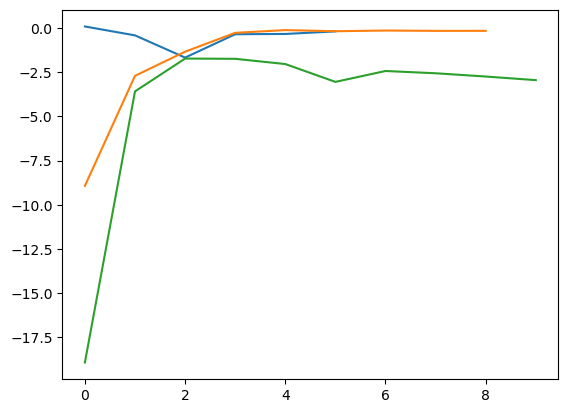

In [13]:
for fold in range(5):
    y = np.array(training_stats[fold]["val_r2"])
    plt.plot(y, label=f"Fold {fold+1}")
plt.legend()
plt.show()

for fold in range(5):
    y1 = np.array(training_stats[fold]["val_loss"])
    plt.plot(y1, label=f"Fold {fold+1} validation loss")
    y2 = np.array(training_stats[fold]["train_loss"])
    plt.plot(y2, label=f"Fold {fold+1} training loss")
plt.legend()
plt.show()

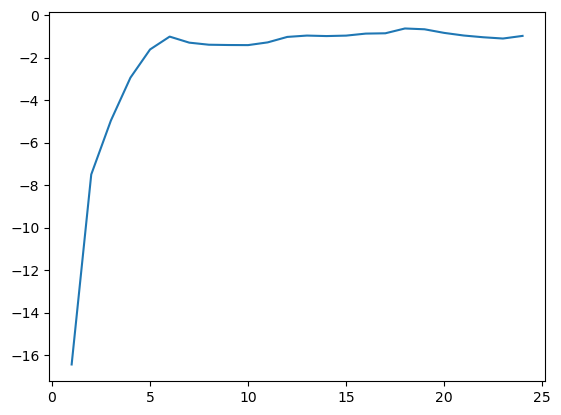

In [ ]:
plt.plot(x, y)
plt.show()